# Clasificacion Automatica de Tickets con NLP

### Integrante

* Roger Oscar Antequera Crespo

## Descripcion del Problema 

Crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Se realizo el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, se aplico NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, se asigno cada ticket a su respectivo departamento/categoría. Luego se usaron los datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, se pudo clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Setup e Importacion de Librerias

Cargamos las librerias necesarias

In [7]:
import json 
import numpy as np
import pandas as pd
import re, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from textblob import TextBlob
tqdm.pandas()
from nltk import bigrams
from nltk import ngrams
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

## Data Loading

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [8]:
#Abrir el archivo JSON
df_json = open('complaints.json') 

#Convertir el archivo json extraido en un dataframe
data = json.load(df_json)
df=pd.json_normalize(data)

## Data Visualization

Una vez obtenido nuestro dataset aplicaremos funciones simples para analizar la data que tenemos para su futuro tratamiento

In [9]:
df.head()

_index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00            CA  ...  Closed with explanation   
1  2019-05-01T12:00:00-05:00            GA  ...  Closed with explanation   
2  2019-04-02T12:00:00-05:00            TX  ...  Closed with explanation   
3  2017-09-13T12:00:00-05:00            MI  ...  Closed with explanation   
4  2019-04-05T12:00:00-05:00            NY  ...  Closed with explanation   

        _source.company _source.submitted_via _source.date_sent_to_company  \
0  JPMORGAN CHASE & CO.                   Web    2019-04-13T12:00:00-05:00   
1  JPMORGAN CHASE & CO.                   Web    2019-05-01T12:00:00-05:00   
2  JPMORGAN CHASE & CO.                   Web    2019-04-02T12:00:00-05:00   
3  JPMORGAN CHASE & CO.                   Web    2017-09-14T12:00:00-05:00   
4  JPMORGAN CHASE & CO.              Referral    2019-04-05T12:00:00-05:00   

  _source.company_public_response                         _source.sub_product  \
0                            None                            Credit card debt   
1                            None                            Credit card debt   
2                            None  General-purpose credit card or charge card   
3                            None                  Conventional home mortgage   
4                            None  General-purpose credit card or charge card   

  _source.timely                    _source.complaint_what_happened  \
0            Yes                                                      
1            Yes  Good morning my name is XXXX XXXX and I apprec...   
2            Yes  I upgraded my XXXX XXXX card in XX/XX/2018 and...   
3            Yes                                                      
4            Yes                                                      

                                  _source.sub_issue  \
0                                 Debt is not yours   
1  Didn't receive enough information to verify debt   
2             Problem with rewards from credit card   
3                                              None   
4                         Charged too much interest   

  _source.consumer_consent_provided  
0              Consent not provided  
1                  Consent provided  
2                  Consent provided  
3              Consent not provided  
4                               N/A  

[5 rows x 22 columns]

In [10]:
df.dtypes

_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue                     object
_source.consumer_consent_provided     object
dtype: obj

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [12]:
#Imprimir las columnas
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## Prepare the text for topic modeling

In [13]:
# Asignamos nuevos nombres a las columnas
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [14]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [15]:
#Asignar NaN a los campos que se encuentran vacios
df['complaint_what_happened'] = np.where(df['complaint_what_happened'] == '', np.nan, df['complaint_what_happened'])
df.head(25)

index       type       id  score            tags zip_code  \
0   complaint-public-v2  complaint  3211475    0.0            None    90301   
1   complaint-public-v2  complaint  3229299    0.0   Servicemember    319XX   
2   complaint-public-v2  complaint  3199379    0.0            None    77069   
3   complaint-public-v2  complaint  2673060    0.0            None    48066   
4   complaint-public-v2  complaint  3203545    0.0            None    10473   
5   complaint-public-v2  complaint  3275312    0.0  Older American    48227   
6   complaint-public-v2  complaint  3238804    0.0            None    76262   
7   complaint-public-v2  complaint  3249272    0.0            None    07753   
8   complaint-public-v2  complaint  3351653    0.0            None    60621   
9   complaint-public-v2  complaint  3273612    0.0            None    99354   
10  complaint-public-v2  complaint  3233499    0.0            None    104XX   
11  complaint-public-v2  complaint  3180294    0.0            None    750XX   
12  complaint-public-v2  complaint  3362102    0.0            None    08701   
13  complaint-public-v2  complaint  3319930    0.0            None    420XX   
14  complaint-public-v2  complaint  3224980    0.0            None    920XX   
15  complaint-public-v2  complaint  3209411    0.0            None     None   
16  complaint-public-v2  complaint  3311133    0.0            None    78748   
17  complaint-public-v2  complaint  3331023    0.0            None    770XX   
18  complaint-public-v2  complaint  2647668    0.0            None    47331   
19  complaint-public-v2  complaint  3300211    0.0            None    32796   
20  complaint-public-v2  complaint  3352857    0.0            None    207XX   
21  complaint-public-v2  complaint  3226110    0.0   Servicemember    846XX   
22  complaint-public-v2  complaint  3252393    0.0            None    84005   
23  complaint-public-v2  complaint  3237765    0.0            None    330XX   
24  complaint-public-v2  complaint  3200018    0.0            None    112XX   

   complaint_id                                     issue  \
0       3211475         Attempts to collect debt not owed   
1       3229299           Written notification about debt   
2       3199379        Other features, terms, or problems   
3       2673060            Trouble during payment process   
4       3203545                          Fees or interest   
5       3275312                       Managing an account   
6       3238804                       Managing an account   
7       3249272            Trouble during payment process   
8       3351653                        Closing an account   
9       3273612                       Managing an account   
10      3233499      Incorrect information on your report   
11      3180294      Incorrect information on your report   
12      3362102                        Closing an account   
13      3319930      Incorrect information on your report   
14      3224980                       Managing an account   
15      3209411               Improper use of your report   
16      3311133                       Managing an account   
17      3331023                        Closing an account   
18      2647668                Struggling to pay mortgage   
19      3300211           Written notification about debt   
20      3352857               Struggling to pay your loan   
21      3226110                             Fraud or scam   
22      3252393      Incorrect information on your report   
23      3237765      Incorrect information on your report   
24      3200018  Problems at the end of the loan or lease   

                date_received state  ...                 company_response  \
0   2019-04-13T12:00:00-05:00    CA  ...          Closed with explanation   
1   2019-05-01T12:00:00-05:00    GA  ...          Closed with explanation   
2   2019-04-02T12:00:00-05:00    TX  ...          Closed with explanation   
3   2017-09-13T12:00:00-05:00    MI  ...          Closed with explan

In [16]:
# Eliminamos los valores nulos
masc_nulls = df.isna()
vals_nulls = masc_nulls.sum()

In [17]:
vals_nulls

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [18]:
df = df.dropna(subset=['complaint_what_happened'])
df = df.reset_index(drop=True)

In [19]:
masc_nulls = df.isna()
vals_nulls = masc_nulls.sum()

In [20]:
#Verificamos que la columna complaint no tiene nulls
vals_nulls

index                            0
type                             0
id                               0
score                            0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

Una vez que eliminado todas las quejas en blanco, proseguimos con:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez realizado estas operaciones de limpieza, se prosigue con lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [21]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [22]:
#Limpiamos el texto y eliminamos todos los elementos innecesarios
def cleaned_text(sent):
    sent = sent.lower() 
    pattern = '[^\w\s]'
    sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d\w*'
    sent = re.sub(pattern, '', sent) 
    return sent

In [23]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(cleaned_text))

In [24]:
df_clean

complaint_what_happened
0      good morning my name is xxxx xxxx and i apprec...
1      i upgraded my xxxx xxxx card in  and was told ...
2      chase card was reported on  however fraudulent...
3      on  while trying to book a xxxx  xxxx  ticket ...
4      my grand son give me check for  i deposit it i...
...                                                  ...
21067  after being a chase card customer for well ove...
21068  on wednesday xxxxxxxx i called chas my xxxx xx...
21069  i am not familiar with xxxx pay and did not un...
21070  i have had flawless credit for  yrs ive had ch...
21071  roughly  years ago i closed out my accounts wi...

[21072 rows x 1 columns]

In [25]:
#Lematizamos el texto
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatized_text(sentence):
   
    words = nltk.word_tokenize(sentence)
    
    words = [word for word in words if word not in stopwords.words("english")]
    
    nltk_tagged = nltk.pos_tag(words)
    
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [26]:
# Creamos el dataframe df_clean que contiene el texto lematizado
df_clean = pd.DataFrame()

for x in tqdm(df.complaint_what_happened):
    df_clean = df_clean.append({'complaint_what_happened':x, 'lemmatized_complaints':lemmatized_text(cleaned_text(x))}, ignore_index=True)

  0%|          | 0/21072 [00:00<?, ?it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  0%|          | 1/21072 [00:01<9:44:51,  1.67s/it]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  0%|          | 4/21072 [00:01<2:01:48,  2.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806

  0%|          | 38/21072 [00:03<18:05, 19.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  0%|          | 41/21072 [00:04<34:53, 10.04it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.appe

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  0%|          | 78/21072 [00:06<16:21, 21.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  0%|          | 81/21072 [00:06<17:10, 20.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.appe

  1%|          | 115/21072 [00:10<40:14,  8.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 117/21072 [00:10<35:38,  9.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 119/21072 [00:10<36:43,  9.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel

  1%|          | 153/21072 [00:14<30:21, 11.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 156/21072 [00:14<25:31, 13.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  1%|          | 190/21072 [00:16<22:42, 15.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 192/21072 [00:16<22:40, 15.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 194/21072 [00:16<22:57, 15.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 229/21072 [00:19<22:29, 15.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|          | 231/21072 [00:19<29:17, 11.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  1%|▏         | 265/21072 [00:21<19:15, 18.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|▏         | 268/21072 [00:21<18:13, 19.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  1%|▏         | 304/21072 [00:24<24:57, 13.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  1%|▏         | 307/21072 [00:24<23:35, 14.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 344/21072 [00:27<21:42, 15.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 346/21072 [00:27<27:02, 12.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  2%|▏         | 380/21072 [00:29<22:44, 15.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 382/21072 [00:30<23:52, 14.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 384/21072 [00:30<23:35, 14.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 419/21072 [00:32<19:54, 17.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 422/21072 [00:33<18:33, 18.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  2%|▏         | 456/21072 [00:36<23:02, 14.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 458/21072 [00:36<25:33, 13.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  2%|▏         | 495/21072 [00:39<26:38, 12.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  2%|▏         | 498/21072 [00:39<22:38, 15.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  3%|▎         | 532/21072 [00:42<22:01, 15.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 535/21072 [00:42<22:11, 15.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 572/21072 [00:44<24:51, 13.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 575/21072 [00:44<22:05, 15.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  3%|▎         | 608/21072 [00:46<23:33, 14.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 610/21072 [00:47<27:14, 12.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  3%|▎         | 647/21072 [00:49<18:36, 18.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 650/21072 [00:49<18:29, 18.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 686/21072 [00:52<21:14, 15.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 688/21072 [00:52<20:48, 16.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  3%|▎         | 724/21072 [00:54<16:21, 20.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  3%|▎         | 727/21072 [00:54<15:30, 21.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  4%|▎         | 763/21072 [00:56<22:56, 14.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▎         | 767/21072 [00:56<18:05, 18.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  4%|▍         | 800/21072 [00:59<24:20, 13.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▍         | 802/21072 [00:59<24:37, 13.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▍         | 804/21072 [00:59<22:51, 14.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel

  4%|▍         | 837/21072 [01:01<21:10, 15.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▍         | 839/21072 [01:01<25:33, 13.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▍         | 841/21072 [01:01<24:49, 13.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel

  4%|▍         | 874/21072 [01:04<27:59, 12.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▍         | 878/21072 [01:04<20:24, 16.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  4%|▍         | 911/21072 [01:07<22:21, 15.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  4%|▍         | 914/21072 [01:07<20:07, 16.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  4%|▍         | 948/21072 [01:09<30:04, 11.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▍         | 950/21072 [01:10<28:02, 11.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  5%|▍         | 986/21072 [01:12<23:28, 14.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▍         | 988/21072 [01:12<22:47, 14.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.ap

  5%|▍         | 1026/21072 [01:15<18:06, 18.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▍         | 1029/21072 [01:15<20:12, 16.53it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  5%|▌         | 1064/21072 [01:17<18:05, 18.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▌         | 1067/21072 [01:18<21:14, 15.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  5%|▌         | 1101/21072 [01:21<33:30,  9.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▌         | 1103/21072 [01:21<31:05, 10.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▌         | 1105/21072 [01:21<28:51, 11.53it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

  5%|▌         | 1139/21072 [01:25<40:14,  8.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  5%|▌         | 1142/21072 [01:25<32:17, 10.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  6%|▌         | 1177/21072 [01:27<22:32, 14.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1179/21072 [01:28<23:33, 14.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1181/21072 [01:28<22:23, 14.80it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

  6%|▌         | 1214/21072 [01:31<1:00:45,  5.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1216/21072 [01:31<51:04,  6.48it/s]  C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1218/21072 [01:31<45:54,  7.21it/s]C:\Users\rochi\AppData\Local\Temp\ip

  6%|▌         | 1253/21072 [01:34<22:19, 14.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1255/21072 [01:34<23:02, 14.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1257/21072 [01:34<21:47, 15.16it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

  6%|▌         | 1290/21072 [01:36<20:08, 16.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1292/21072 [01:36<20:53, 15.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▌         | 1294/21072 [01:37<27:11, 12.12it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

  6%|▋         | 1328/21072 [01:38<18:05, 18.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  6%|▋         | 1330/21072 [01:39<19:09, 17.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  6%|▋         | 1368/21072 [01:41<12:42, 25.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1371/21072 [01:41<18:08, 18.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  7%|▋         | 1405/21072 [01:44<19:39, 16.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1408/21072 [01:44<19:07, 17.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  7%|▋         | 1444/21072 [01:46<20:03, 16.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1446/21072 [01:46<20:49, 15.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  7%|▋         | 1481/21072 [01:48<21:33, 15.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1484/21072 [01:49<19:15, 16.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  7%|▋         | 1519/21072 [01:51<30:44, 10.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1521/21072 [01:52<26:54, 12.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  7%|▋         | 1557/21072 [01:54<19:49, 16.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1559/21072 [01:54<29:11, 11.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  7%|▋         | 1561/21072 [01:55<32:19, 10.06it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

  8%|▊         | 1596/21072 [01:56<15:44, 20.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1599/21072 [01:57<19:49, 16.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  8%|▊         | 1635/21072 [01:58<15:35, 20.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1638/21072 [01:59<16:23, 19.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  8%|▊         | 1673/21072 [02:01<19:11, 16.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1676/21072 [02:01<17:25, 18.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1712/21072 [02:03<19:44, 16.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1714/21072 [02:03<21:17, 15.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  8%|▊         | 1750/21072 [02:06<17:25, 18.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1753/21072 [02:06<17:15, 18.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  8%|▊         | 1788/21072 [02:08<19:44, 16.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  8%|▊         | 1791/21072 [02:08<16:59, 18.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▊         | 1826/21072 [02:10<18:25, 17.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▊         | 1828/21072 [02:10<20:50, 15.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  9%|▉         | 1862/21072 [02:12<16:04, 19.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▉         | 1865/21072 [02:12<16:36, 19.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▉         | 1901/21072 [02:14<26:32, 12.04it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▉         | 1903/21072 [02:15<25:50, 12.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  9%|▉         | 1938/21072 [02:18<26:07, 12.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▉         | 1940/21072 [02:18<36:21,  8.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

  9%|▉         | 1976/21072 [02:21<17:36, 18.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

  9%|▉         | 1979/21072 [02:21<16:08, 19.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 10%|▉         | 2013/21072 [02:23<21:00, 15.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|▉         | 2016/21072 [02:24<18:15, 17.40it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 10%|▉         | 2051/21072 [02:25<15:57, 19.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|▉         | 2054/21072 [02:26<18:51, 16.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|▉         | 2090/21072 [02:28<15:51, 19.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|█         | 2127/21072 [02:30<22:58, 13.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|█         | 2129/21072 [02:31<27:41, 11.40it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 10%|█         | 2163/21072 [02:33<19:37, 16.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|█         | 2166/21072 [02:33<18:06, 17.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 10%|█         | 2202/21072 [02:36<22:57, 13.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|█         | 2204/21072 [02:36<29:21, 10.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 10%|█         | 2206/21072 [02:37<33:36,  9.35it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 11%|█         | 2240/21072 [02:39<26:39, 11.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█         | 2242/21072 [02:39<26:14, 11.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█         | 2244/21072 [02:39<23:54, 13.13it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 11%|█         | 2277/21072 [02:41<22:50, 13.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█         | 2279/21072 [02:42<27:23, 11.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█         | 2281/21072 [02:42<24:21, 12.86it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 11%|█         | 2316/21072 [02:45<32:19,  9.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█         | 2319/21072 [02:45<40:56,  7.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 11%|█         | 2354/21072 [02:48<17:00, 18.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█         | 2357/21072 [02:48<20:01, 15.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 11%|█▏        | 2391/21072 [02:51<24:02, 12.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 11%|█▏        | 2393/21072 [02:51<25:08, 12.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 12%|█▏        | 2430/21072 [02:55<23:41, 13.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2432/21072 [02:55<22:11, 14.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2434/21072 [02:55<24:44, 12.55it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 12%|█▏        | 2468/21072 [02:58<32:07,  9.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2470/21072 [02:58<30:47, 10.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2472/21072 [02:58<27:56, 11.09it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 12%|█▏        | 2505/21072 [03:01<20:13, 15.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2507/21072 [03:01<23:40, 13.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2509/21072 [03:01<22:50, 13.54it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 12%|█▏        | 2542/21072 [03:04<29:45, 10.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2544/21072 [03:04<31:49,  9.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2546/21072 [03:04<36:20,  8.50it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2580/21072 [03:07<20:55, 14.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2582/21072 [03:07<21:31, 14.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 12%|█▏        | 2616/21072 [03:09<29:41, 10.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2618/21072 [03:10<39:00,  7.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 12%|█▏        | 2620/21072 [03:10<34:18,  8.96it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2656/21072 [03:12<14:07, 21.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2659/21072 [03:12<13:50, 22.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2695/21072 [03:14<12:59, 23.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2698/21072 [03:14<14:10, 21.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 13%|█▎        | 2732/21072 [03:16<19:29, 15.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2735/21072 [03:16<16:46, 18.23it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 13%|█▎        | 2770/21072 [03:19<25:17, 12.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2773/21072 [03:19<22:10, 13.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 13%|█▎        | 2807/21072 [03:22<30:44,  9.90it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 13%|█▎        | 2810/21072 [03:23<26:13, 11.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 13%|█▎        | 2844/21072 [03:25<28:47, 10.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▎        | 2848/21072 [03:25<26:04, 11.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▎        | 2882/21072 [03:29<38:32,  7.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▎        | 2885/21072 [03:29<30:18, 10.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 14%|█▍        | 2919/21072 [03:31<16:16, 18.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▍        | 2922/21072 [03:31<14:56, 20.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 14%|█▍        | 2957/21072 [03:34<23:33, 12.82it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▍        | 2961/21072 [03:34<17:14, 17.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▍        | 2995/21072 [03:37<23:59, 12.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▍        | 2997/21072 [03:37<23:09, 13.01it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▍        | 3034/21072 [03:39<14:32, 20.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 14%|█▍        | 3037/21072 [03:40<16:02, 18.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▍        | 3072/21072 [03:42<24:05, 12.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▍        | 3074/21072 [03:42<23:11, 12.94it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 15%|█▍        | 3109/21072 [03:45<35:40,  8.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▍        | 3112/21072 [03:46<34:27,  8.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▍        | 3148/21072 [03:48<26:23, 11.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▍        | 3150/21072 [03:48<27:10, 10.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▌        | 3185/21072 [03:51<20:38, 14.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▌        | 3187/21072 [03:51<19:08, 15.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 15%|█▌        | 3222/21072 [03:54<23:16, 12.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▌        | 3225/21072 [03:54<21:25, 13.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▌        | 3260/21072 [03:57<21:30, 13.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 15%|█▌        | 3262/21072 [03:57<24:50, 11.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 16%|█▌        | 3296/21072 [03:59<21:44, 13.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▌        | 3298/21072 [04:00<31:09,  9.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▌        | 3300/21072 [04:00<26:49, 11.04it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 16%|█▌        | 3333/21072 [04:02<23:14, 12.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▌        | 3336/21072 [04:02<19:28, 15.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 16%|█▌        | 3371/21072 [04:05<24:14, 12.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▌        | 3373/21072 [04:05<23:31, 12.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▌        | 3375/21072 [04:05<24:33, 12.01it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 16%|█▌        | 3408/21072 [04:08<28:49, 10.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▌        | 3411/21072 [04:08<24:27, 12.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▋        | 3446/21072 [04:11<19:00, 15.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 16%|█▋        | 3448/21072 [04:11<20:01, 14.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 17%|█▋        | 3483/21072 [04:14<15:50, 18.50it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3486/21072 [04:14<15:46, 18.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3523/21072 [04:17<19:48, 14.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3526/21072 [04:17<18:02, 16.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 17%|█▋        | 3560/21072 [04:19<15:46, 18.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3562/21072 [04:19<32:19,  9.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 17%|█▋        | 3599/21072 [04:22<18:42, 15.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3601/21072 [04:23<19:17, 15.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3603/21072 [04:23<18:58, 15.35it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3637/21072 [04:25<22:34, 12.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3639/21072 [04:25<25:32, 11.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 17%|█▋        | 3675/21072 [04:28<17:14, 16.82it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3677/21072 [04:28<18:31, 15.64it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 17%|█▋        | 3679/21072 [04:28<17:40, 16.40it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 18%|█▊        | 3712/21072 [04:30<18:19, 15.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3715/21072 [04:30<15:41, 18.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3750/21072 [04:34<40:00,  7.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3753/21072 [04:34<30:03,  9.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3788/21072 [04:36<15:43, 18.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3790/21072 [04:36<15:34, 18.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3824/21072 [04:39<24:51, 11.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3826/21072 [04:39<26:05, 11.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 18%|█▊        | 3860/21072 [04:41<14:35, 19.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 18%|█▊        | 3863/21072 [04:42<19:33, 14.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 18%|█▊        | 3898/21072 [04:45<35:50,  7.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▊        | 3902/21072 [04:45<24:09, 11.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 19%|█▊        | 3935/21072 [04:48<27:50, 10.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▊        | 3937/21072 [04:49<40:28,  7.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▊        | 3939/21072 [04:49<33:56,  8.41it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 19%|█▉        | 3972/21072 [04:51<25:05, 11.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 3974/21072 [04:51<25:54, 11.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 19%|█▉        | 4009/21072 [04:55<30:55,  9.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 4011/21072 [04:55<29:10,  9.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 4013/21072 [04:55<28:40,  9.91it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 19%|█▉        | 4046/21072 [04:58<18:56, 14.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 4048/21072 [04:58<24:16, 11.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 4050/21072 [04:59<22:57, 12.36it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 19%|█▉        | 4083/21072 [05:01<21:39, 13.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 4085/21072 [05:01<24:46, 11.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 19%|█▉        | 4087/21072 [05:01<24:08, 11.73it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 20%|█▉        | 4121/21072 [05:04<20:29, 13.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|█▉        | 4123/21072 [05:04<24:49, 11.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|█▉        | 4125/21072 [05:04<23:43, 11.91it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 20%|█▉        | 4158/21072 [05:07<32:29,  8.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|█▉        | 4160/21072 [05:07<37:59,  7.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 20%|█▉        | 4195/21072 [05:10<35:11,  7.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|█▉        | 4199/21072 [05:10<27:05, 10.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|██        | 4234/21072 [05:13<20:22, 13.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|██        | 4236/21072 [05:13<19:22, 14.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 20%|██        | 4270/21072 [05:15<19:04, 14.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|██        | 4272/21072 [05:16<22:50, 12.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|██        | 4274/21072 [05:16<25:01, 11.19it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 20%|██        | 4310/21072 [05:18<16:14, 17.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 20%|██        | 4313/21072 [05:18<14:29, 19.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 21%|██        | 4347/21072 [05:20<15:33, 17.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██        | 4349/21072 [05:20<15:31, 17.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██        | 4351/21072 [05:20<16:10, 17.23it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██        | 4386/21072 [05:23<15:52, 17.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 21%|██        | 4422/21072 [05:25<13:50, 20.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██        | 4425/21072 [05:26<18:07, 15.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██        | 4460/21072 [05:29<25:28, 10.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██        | 4462/21072 [05:29<23:05, 11.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 21%|██▏       | 4497/21072 [05:32<13:08, 21.01it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 21%|██▏       | 4500/21072 [05:32<20:58, 13.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4535/21072 [05:35<16:59, 16.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4537/21072 [05:35<18:25, 14.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 22%|██▏       | 4572/21072 [05:38<27:15, 10.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4575/21072 [05:38<20:49, 13.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 22%|██▏       | 4611/21072 [05:41<26:27, 10.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4614/21072 [05:42<22:07, 12.40it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 22%|██▏       | 4648/21072 [05:44<19:06, 14.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4650/21072 [05:44<18:43, 14.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4652/21072 [05:44<17:44, 15.42it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 22%|██▏       | 4687/21072 [05:48<26:37, 10.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4689/21072 [05:48<24:56, 10.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 22%|██▏       | 4725/21072 [05:50<12:23, 22.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 22%|██▏       | 4728/21072 [05:50<14:37, 18.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 23%|██▎       | 4762/21072 [05:53<21:41, 12.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 23%|██▎       | 4765/21072 [05:54<18:05, 15.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 23%|██▎       | 4799/21072 [05:56<26:22, 10.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 23%|██▎       | 4801/21072 [05:57<31:35,  8.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 23%|██▎       | 4837/21072 [06:01<21:19, 12.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 23%|██▎       | 4840/21072 [06:01<17:03, 15.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 23%|██▎       | 4875/21072 [06:03<15:28, 17.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 23%|██▎       | 4878/21072 [06:03<13:33, 19.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 23%|██▎       | 4914/21072 [06:05<15:20, 17.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 23%|██▎       | 4950/21072 [06:08<15:25, 17.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▎       | 4953/21072 [06:08<22:24, 11.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 24%|██▎       | 4988/21072 [06:11<28:04,  9.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▎       | 4990/21072 [06:11<26:40, 10.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▍       | 5027/21072 [06:14<18:07, 14.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▍       | 5029/21072 [06:14<21:19, 12.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 24%|██▍       | 5063/21072 [06:17<31:08,  8.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▍       | 5065/21072 [06:17<29:31,  9.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▍       | 5067/21072 [06:17<28:57,  9.21it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 24%|██▍       | 5102/21072 [06:20<20:22, 13.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▍       | 5104/21072 [06:20<22:58, 11.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 24%|██▍       | 5141/21072 [06:23<17:44, 14.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 25%|██▍       | 5178/21072 [06:25<15:53, 16.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▍       | 5181/21072 [06:25<15:01, 17.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▍       | 5216/21072 [06:28<24:15, 10.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▍       | 5219/21072 [06:28<19:13, 13.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▍       | 5254/21072 [06:31<20:22, 12.94it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▍       | 5256/21072 [06:31<19:21, 13.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 25%|██▌       | 5291/21072 [06:33<19:15, 13.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▌       | 5293/21072 [06:34<22:25, 11.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▌       | 5295/21072 [06:34<27:20,  9.62it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▌       | 5331/21072 [06:36<15:31, 16.90it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▌       | 5334/21072 [06:37<13:46, 19.04it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 25%|██▌       | 5368/21072 [06:40<17:45, 14.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|██▌       | 5372/21072 [06:40<18:30, 14.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5406/21072 [06:44<25:57, 10.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5408/21072 [06:44<28:45,  9.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 26%|██▌       | 5443/21072 [06:48<20:20, 12.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5445/21072 [06:48<21:18, 12.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5447/21072 [06:48<26:27,  9.84it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 26%|██▌       | 5480/21072 [06:51<20:52, 12.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5482/21072 [06:51<19:12, 13.53it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5484/21072 [06:51<18:04, 14.37it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 26%|██▌       | 5517/21072 [06:54<20:37, 12.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▌       | 5519/21072 [06:54<20:31, 12.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 26%|██▋       | 5555/21072 [06:57<15:59, 16.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 26%|██▋       | 5557/21072 [06:57<15:51, 16.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5593/21072 [07:01<25:26, 10.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5595/21072 [07:01<24:30, 10.53it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 27%|██▋       | 5629/21072 [07:03<13:48, 18.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5632/21072 [07:03<12:26, 20.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 27%|██▋       | 5666/21072 [07:06<27:05,  9.47it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5668/21072 [07:07<28:01,  9.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5670/21072 [07:07<30:14,  8.49it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 27%|██▋       | 5704/21072 [07:10<16:16, 15.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5706/21072 [07:10<26:07,  9.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5708/21072 [07:10<23:15, 11.01it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5742/21072 [07:13<18:33, 13.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 27%|██▋       | 5779/21072 [07:16<16:50, 15.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 27%|██▋       | 5783/21072 [07:16<19:53, 12.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 28%|██▊       | 5816/21072 [07:19<23:27, 10.84it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5818/21072 [07:19<24:58, 10.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5854/21072 [07:21<23:16, 10.90it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5856/21072 [07:22<20:37, 12.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5893/21072 [07:25<17:42, 14.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5896/21072 [07:25<17:13, 14.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 28%|██▊       | 5929/21072 [07:30<38:48,  6.50it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5932/21072 [07:30<30:35,  8.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5968/21072 [07:33<13:12, 19.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 5970/21072 [07:33<13:42, 18.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 28%|██▊       | 6005/21072 [07:35<15:21, 16.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▊       | 6008/21072 [07:36<17:28, 14.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 29%|██▊       | 6041/21072 [07:38<20:41, 12.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▊       | 6043/21072 [07:38<21:54, 11.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▊       | 6045/21072 [07:38<22:21, 11.20it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 29%|██▉       | 6080/21072 [07:42<23:40, 10.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6083/21072 [07:42<26:05,  9.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6118/21072 [07:46<44:03,  5.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6121/21072 [07:46<32:24,  7.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6155/21072 [07:50<29:04,  8.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6156/21072 [07:50<28:27,  8.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6158/21072 [07:50<23:55, 10.39it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6192/21072 [07:53<17:28, 14.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 29%|██▉       | 6194/21072 [07:53<22:22, 11.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|██▉       | 6231/21072 [07:56<15:37, 15.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|██▉       | 6233/21072 [07:56<16:22, 15.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 30%|██▉       | 6269/21072 [07:58<10:50, 22.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|██▉       | 6272/21072 [07:58<11:37, 21.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 30%|██▉       | 6307/21072 [08:01<19:29, 12.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|██▉       | 6310/21072 [08:01<15:59, 15.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 30%|███       | 6345/21072 [08:04<15:44, 15.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|███       | 6347/21072 [08:04<21:23, 11.47it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|███       | 6349/21072 [08:04<30:35,  8.02it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|███       | 6384/21072 [08:08<23:54, 10.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|███       | 6422/21072 [08:10<11:59, 20.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 30%|███       | 6425/21072 [08:10<19:27, 12.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 31%|███       | 6459/21072 [08:13<13:36, 17.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███       | 6463/21072 [08:13<12:48, 19.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 31%|███       | 6496/21072 [08:15<15:11, 15.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███       | 6498/21072 [08:16<19:55, 12.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███       | 6500/21072 [08:16<17:57, 13.53it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███       | 6536/21072 [08:19<14:15, 16.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███       | 6571/21072 [08:22<17:54, 13.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███       | 6574/21072 [08:22<15:12, 15.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███▏      | 6609/21072 [08:25<14:12, 16.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 31%|███▏      | 6612/21072 [08:25<14:07, 17.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6647/21072 [08:28<16:07, 14.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6650/21072 [08:28<14:21, 16.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6684/21072 [08:30<14:17, 16.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6686/21072 [08:31<14:34, 16.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 32%|███▏      | 6720/21072 [08:33<17:00, 14.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6722/21072 [08:33<16:16, 14.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6724/21072 [08:33<19:30, 12.25it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 32%|███▏      | 6757/21072 [08:36<26:34,  8.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6759/21072 [08:36<23:06, 10.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6761/21072 [08:36<21:16, 11.21it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 32%|███▏      | 6795/21072 [08:39<25:03,  9.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6798/21072 [08:39<18:54, 12.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6834/21072 [08:42<18:02, 13.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 32%|███▏      | 6836/21072 [08:42<18:51, 12.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 33%|███▎      | 6870/21072 [08:44<16:14, 14.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 6872/21072 [08:44<15:04, 15.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 33%|███▎      | 6908/21072 [08:46<11:58, 19.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 6911/21072 [08:47<14:56, 15.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 6946/21072 [08:49<13:50, 17.01it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 6948/21072 [08:49<14:01, 16.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 33%|███▎      | 6982/21072 [08:52<21:03, 11.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 6985/21072 [08:52<20:16, 11.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 33%|███▎      | 7020/21072 [08:54<14:15, 16.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 7023/21072 [08:54<13:19, 17.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 33%|███▎      | 7057/21072 [08:57<18:12, 12.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 33%|███▎      | 7059/21072 [08:57<16:53, 13.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▎      | 7098/21072 [09:01<18:19, 12.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▎      | 7101/21072 [09:01<17:45, 13.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▍      | 7136/21072 [09:03<11:26, 20.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▍      | 7139/21072 [09:03<13:27, 17.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 34%|███▍      | 7174/21072 [09:06<23:20,  9.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▍      | 7177/21072 [09:06<18:35, 12.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 34%|███▍      | 7211/21072 [09:09<20:45, 11.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▍      | 7215/21072 [09:09<16:07, 14.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 34%|███▍      | 7249/21072 [09:11<15:15, 15.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 35%|███▍      | 7285/21072 [09:15<19:33, 11.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▍      | 7287/21072 [09:15<18:14, 12.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▍      | 7289/21072 [09:15<29:56,  7.67it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 35%|███▍      | 7322/21072 [09:18<17:09, 13.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▍      | 7325/21072 [09:18<14:15, 16.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 35%|███▍      | 7360/21072 [09:20<11:11, 20.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▍      | 7363/21072 [09:20<12:34, 18.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▌      | 7398/21072 [09:23<10:02, 22.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▌      | 7401/21072 [09:23<11:51, 19.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 35%|███▌      | 7435/21072 [09:26<16:00, 14.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▌      | 7438/21072 [09:26<13:43, 16.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 35%|███▌      | 7472/21072 [09:29<18:46, 12.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 35%|███▌      | 7474/21072 [09:29<20:59, 10.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▌      | 7511/21072 [09:31<12:39, 17.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▌      | 7514/21072 [09:31<11:21, 19.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 36%|███▌      | 7548/21072 [09:33<16:36, 13.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▌      | 7550/21072 [09:33<19:11, 11.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 36%|███▌      | 7585/21072 [09:35<12:39, 17.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▌      | 7588/21072 [09:35<12:05, 18.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 36%|███▌      | 7622/21072 [09:38<12:12, 18.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▌      | 7624/21072 [09:38<16:58, 13.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▋      | 7661/21072 [09:41<18:52, 11.84it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 36%|███▋      | 7663/21072 [09:41<19:32, 11.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 37%|███▋      | 7698/21072 [09:44<20:27, 10.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7700/21072 [09:44<19:08, 11.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7702/21072 [09:44<17:51, 12.47it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7737/21072 [09:47<14:04, 15.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7739/21072 [09:47<19:09, 11.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 37%|███▋      | 7772/21072 [09:50<20:34, 10.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7775/21072 [09:50<16:06, 13.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 37%|███▋      | 7809/21072 [09:52<14:47, 14.94it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7812/21072 [09:52<15:25, 14.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 37%|███▋      | 7847/21072 [09:55<14:09, 15.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7851/21072 [09:55<14:29, 15.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 37%|███▋      | 7885/21072 [09:58<16:31, 13.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7887/21072 [09:58<20:16, 10.84it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 37%|███▋      | 7889/21072 [09:58<19:50, 11.08it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 38%|███▊      | 7924/21072 [10:00<13:45, 15.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 7927/21072 [10:01<12:22, 17.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 7962/21072 [10:04<19:24, 11.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 7964/21072 [10:04<18:14, 11.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 38%|███▊      | 7998/21072 [10:06<17:19, 12.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 8000/21072 [10:06<17:41, 12.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 8002/21072 [10:07<17:08, 12.71it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 38%|███▊      | 8035/21072 [10:09<17:25, 12.47it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 8037/21072 [10:09<16:39, 13.04it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 38%|███▊      | 8039/21072 [10:09<17:08, 12.67it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 38%|███▊      | 8074/21072 [10:12<14:00, 15.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 38%|███▊      | 8112/21072 [10:15<17:31, 12.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▊      | 8115/21072 [10:15<15:26, 13.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 39%|███▊      | 8151/21072 [10:18<14:13, 15.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▊      | 8153/21072 [10:18<13:57, 15.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 39%|███▉      | 8188/21072 [10:21<17:20, 12.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8190/21072 [10:21<15:46, 13.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8192/21072 [10:21<18:48, 11.42it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8227/21072 [10:25<22:23,  9.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8229/21072 [10:25<23:43,  9.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8265/21072 [10:27<12:42, 16.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8267/21072 [10:27<13:07, 16.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 39%|███▉      | 8302/21072 [10:30<15:54, 13.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|███▉      | 8339/21072 [10:33<15:01, 14.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|███▉      | 8378/21072 [10:35<11:50, 17.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 40%|███▉      | 8414/21072 [10:38<17:36, 11.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|███▉      | 8417/21072 [10:38<13:38, 15.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|████      | 8452/21072 [10:41<15:33, 13.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|████      | 8454/21072 [10:41<14:55, 14.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 40%|████      | 8490/21072 [10:44<16:30, 12.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|████      | 8492/21072 [10:44<15:21, 13.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 40%|████      | 8528/21072 [10:47<16:05, 13.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 41%|████      | 8565/21072 [10:49<15:31, 13.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 41%|████      | 8568/21072 [10:49<13:02, 15.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 41%|████      | 8604/21072 [10:52<12:45, 16.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 41%|████      | 8643/21072 [10:54<10:11, 20.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 41%|████      | 8646/21072 [10:54<10:15, 20.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 41%|████      | 8681/21072 [10:56<14:24, 14.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 41%|████      | 8683/21072 [10:57<19:01, 10.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 41%|████      | 8685/21072 [10:57<18:09, 11.37it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 41%|████▏     | 8719/21072 [10:59<10:20, 19.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 41%|████▏     | 8722/21072 [10:59<16:18, 12.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8758/21072 [11:02<19:20, 10.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8760/21072 [11:02<17:36, 11.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 42%|████▏     | 8793/21072 [11:05<17:56, 11.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8795/21072 [11:05<18:23, 11.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8797/21072 [11:05<19:07, 10.70it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 42%|████▏     | 8830/21072 [11:09<16:58, 12.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8832/21072 [11:09<15:28, 13.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 42%|████▏     | 8868/21072 [11:12<15:42, 12.94it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8870/21072 [11:12<18:54, 10.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8908/21072 [11:14<11:03, 18.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 42%|████▏     | 8945/21072 [11:16<13:57, 14.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 42%|████▏     | 8948/21072 [11:17<12:52, 15.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 8983/21072 [11:19<09:23, 21.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 8986/21072 [11:19<08:50, 22.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9021/21072 [11:21<15:07, 13.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9023/21072 [11:21<14:37, 13.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9059/21072 [11:25<12:48, 15.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9061/21072 [11:26<15:05, 13.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 43%|████▎     | 9096/21072 [11:28<11:14, 17.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9099/21072 [11:29<12:34, 15.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9134/21072 [11:31<16:19, 12.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 43%|████▎     | 9137/21072 [11:31<12:57, 15.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 44%|████▎     | 9170/21072 [11:35<28:29,  6.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▎     | 9172/21072 [11:35<24:35,  8.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▎     | 9174/21072 [11:36<22:34,  8.79it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 44%|████▎     | 9207/21072 [11:39<17:39, 11.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▎     | 9210/21072 [11:39<13:54, 14.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 44%|████▍     | 9245/21072 [11:43<20:32,  9.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▍     | 9247/21072 [11:43<19:04, 10.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▍     | 9284/21072 [11:45<13:11, 14.90it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▍     | 9286/21072 [11:46<12:20, 15.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▍     | 9323/21072 [11:48<11:04, 17.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 44%|████▍     | 9326/21072 [11:48<11:20, 17.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 44%|████▍     | 9361/21072 [11:51<14:30, 13.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from

 45%|████▍     | 9399/21072 [11:54<21:22,  9.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 45%|████▍     | 9401/21072 [11:54<21:24,  9.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 45%|████▍     | 9436/21072 [11:57<21:28,  9.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 45%|████▍     | 9438/21072 [11:58<21:24,  9.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 45%|████▍     | 9474/21072 [12:01<30:14,  6.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 45%|████▍     | 9477/21072 [12:02<22:56,  8.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 45%|████▌     | 9511/21072 [12:04<15:03, 12.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 45%|████▌     | 9513/21072 [12:05<20:14,  9.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 45%|████▌     | 9548/21072 [12:07<13:30, 14.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 45%|████▌     | 9551/21072 [12:07<12:30, 15.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 45%|████▌     | 9585/21072 [12:10<13:02, 14.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9588/21072 [12:10<11:03, 17.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 46%|████▌     | 9623/21072 [12:13<19:47,  9.64it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9625/21072 [12:13<18:08, 10.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9627/21072 [12:13<16:44, 11.39it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9662/21072 [12:15<10:43, 17.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9665/21072 [12:15<09:58, 19.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 46%|████▌     | 9701/21072 [12:17<12:01, 15.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9703/21072 [12:18<14:38, 12.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9705/21072 [12:18<14:49, 12.77it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

 46%|████▌     | 9739/21072 [12:20<13:21, 14.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9741/21072 [12:20<15:13, 12.40it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▌     | 9743/21072 [12:21<15:35, 12.12it/s]C:\Users\rochi\AppData\Local\Temp\ipyker

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▋     | 9777/21072 [12:23<11:39, 16.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 46%|████▋     | 9779/21072 [12:24<11:39, 16.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 47%|████▋     | 9813/21072 [12:27<23:00,  8.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 9815/21072 [12:27<19:14,  9.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 47%|████▋     | 9853/21072 [12:29<13:10, 14.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 9855/21072 [12:29<14:46, 12.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 9891/21072 [12:32<13:48, 13.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 9893/21072 [12:33<14:46, 12.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 47%|████▋     | 9928/21072 [12:35<12:21, 15.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 9931/21072 [12:35<12:34, 14.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 47%|████▋     | 9966/21072 [12:38<18:05, 10.23it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 9969/21072 [12:38<15:07, 12.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.

 47%|████▋     | 10004/21072 [12:40<14:26, 12.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 47%|████▋     | 10006/21072 [12:40<15:57, 11.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 48%|████▊     | 10041/21072 [12:43<14:55, 12.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10044/21072 [12:43<15:53, 11.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10080/21072 [12:45<11:05, 16.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10082/21072 [12:46<15:00, 12.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 48%|████▊     | 10117/21072 [12:48<15:44, 11.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10119/21072 [12:49<20:34,  8.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10121/21072 [12:49<17:47, 10.26it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 48%|████▊     | 10155/21072 [12:51<16:25, 11.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10157/21072 [12:51<14:53, 12.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10159/21072 [12:52<16:04, 11.32it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 48%|████▊     | 10192/21072 [12:54<14:33, 12.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10194/21072 [12:54<13:16, 13.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 48%|████▊     | 10196/21072 [12:55<12:51, 14.09it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 49%|████▊     | 10230/21072 [12:57<17:00, 10.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▊     | 10232/21072 [12:58<14:51, 12.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▊     | 10234/21072 [12:58<15:09, 11.92it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 49%|████▊     | 10267/21072 [13:00<09:18, 19.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▊     | 10269/21072 [13:00<09:30, 18.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 49%|████▉     | 10304/21072 [13:03<10:46, 16.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▉     | 10306/21072 [13:03<13:59, 12.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▉     | 10308/21072 [13:03<15:16, 11.74it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▉     | 10342/21072 [13:05<12:59, 13.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 49%|████▉     | 10378/21072 [13:08<10:15, 17.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▉     | 10382/21072 [13:08<08:26, 21.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 49%|████▉     | 10415/21072 [13:11<17:37, 10.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 49%|████▉     | 10417/21072 [13:11<15:33, 11.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 50%|████▉     | 10453/21072 [13:14<18:20,  9.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|████▉     | 10455/21072 [13:15<18:34,  9.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|████▉     | 10457/21072 [13:15<19:10,  9.22it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 50%|████▉     | 10490/21072 [13:17<16:29, 10.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|████▉     | 10492/21072 [13:17<15:14, 11.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|████▉     | 10494/21072 [13:18<17:30, 10.06it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 50%|████▉     | 10527/21072 [13:20<10:53, 16.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|████▉     | 10530/21072 [13:20<10:31, 16.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 50%|█████     | 10565/21072 [13:22<12:02, 14.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|█████     | 10567/21072 [13:22<12:18, 14.23it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|█████     | 10604/21072 [13:25<11:26, 15.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|█████     | 10606/21072 [13:25<13:23, 13.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 50%|█████     | 10639/21072 [13:27<12:54, 13.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████     | 10642/21072 [13:28<13:54, 12.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 51%|█████     | 10676/21072 [13:30<11:49, 14.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████     | 10679/21072 [13:30<11:14, 15.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 51%|█████     | 10715/21072 [13:33<08:08, 21.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████     | 10718/21072 [13:33<09:04, 19.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 51%|█████     | 10752/21072 [13:36<10:34, 16.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 51%|█████     | 10789/21072 [13:39<14:31, 11.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████     | 10791/21072 [13:39<14:27, 11.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████     | 10793/21072 [13:39<12:55, 13.25it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 51%|█████▏    | 10826/21072 [13:42<16:00, 10.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████▏    | 10828/21072 [13:42<14:50, 11.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 51%|█████▏    | 10830/21072 [13:42<16:37, 10.27it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 52%|█████▏    | 10863/21072 [13:45<13:51, 12.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 10865/21072 [13:45<15:37, 10.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 10867/21072 [13:45<14:14, 11.95it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 52%|█████▏    | 10901/21072 [13:48<11:05, 15.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 10903/21072 [13:48<12:18, 13.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 52%|█████▏    | 10938/21072 [13:51<12:09, 13.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 10940/21072 [13:51<14:27, 11.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 10942/21072 [13:52<22:35,  7.48it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 52%|█████▏    | 10976/21072 [13:54<13:27, 12.50it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 10978/21072 [13:54<14:10, 11.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 11014/21072 [13:58<14:03, 11.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 11016/21072 [13:58<12:35, 13.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 52%|█████▏    | 11051/21072 [14:00<12:54, 12.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 52%|█████▏    | 11053/21072 [14:00<11:50, 14.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 53%|█████▎    | 11088/21072 [14:04<18:16,  9.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 53%|█████▎    | 11090/21072 [14:04<16:47,  9.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 53%|█████▎    | 11092/21072 [14:04<17:33,  9.47it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 53%|█████▎    | 11125/21072 [14:07<16:39,  9.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 53%|█████▎    | 11128/21072 [14:07<16:02, 10.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 53%|█████▎    | 11162/21072 [14:09<14:01, 11.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 53%|█████▎    | 11165/21072 [14:10<12:13, 13.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 53%|█████▎    | 11199/21072 [14:12<09:12, 17.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 53%|█████▎    | 11202/21072 [14:12<09:37, 17.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 53%|█████▎    | 11237/21072 [14:15<14:02, 11.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 53%|█████▎    | 11239/21072 [14:16<23:55,  6.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 54%|█████▎    | 11274/21072 [14:20<12:49, 12.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▎    | 11276/21072 [14:20<14:07, 11.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▎    | 11278/21072 [14:20<13:57, 11.70it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▎    | 11313/21072 [14:22<07:41, 21.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▎    | 11316/21072 [14:22<07:50, 20.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 54%|█████▍    | 11351/21072 [14:25<13:32, 11.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▍    | 11353/21072 [14:25<15:00, 10.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 54%|█████▍    | 11388/21072 [14:28<11:48, 13.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▍    | 11390/21072 [14:28<13:44, 11.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▍    | 11392/21072 [14:28<12:26, 12.97it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 54%|█████▍    | 11425/21072 [14:32<14:49, 10.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▍    | 11428/21072 [14:32<12:17, 13.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 54%|█████▍    | 11463/21072 [14:36<14:34, 10.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 55%|█████▍    | 11499/21072 [14:38<09:51, 16.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▍    | 11501/21072 [14:38<10:08, 15.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▍    | 11537/21072 [14:40<12:50, 12.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▍    | 11539/21072 [14:41<15:15, 10.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 55%|█████▍    | 11573/21072 [14:43<13:43, 11.53it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▍    | 11575/21072 [14:44<13:23, 11.82it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 55%|█████▌    | 11613/21072 [14:46<08:18, 18.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▌    | 11616/21072 [14:46<08:53, 17.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▌    | 11652/21072 [14:49<09:55, 15.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 55%|█████▌    | 11687/21072 [14:52<14:03, 11.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 55%|█████▌    | 11690/21072 [14:52<11:32, 13.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 56%|█████▌    | 11725/21072 [14:54<08:44, 17.82it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▌    | 11727/21072 [14:55<12:57, 12.01it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▌    | 11729/21072 [14:55<12:32, 12.41it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▌    | 11763/21072 [14:57<11:39, 13.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▌    | 11765/21072 [14:58<12:35, 12.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 56%|█████▌    | 11800/21072 [15:00<11:31, 13.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▌    | 11804/21072 [15:00<08:38, 17.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 56%|█████▌    | 11837/21072 [15:04<15:47,  9.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▌    | 11839/21072 [15:05<18:00,  8.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 56%|█████▋    | 11874/21072 [15:07<10:37, 14.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▋    | 11876/21072 [15:08<12:24, 12.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 56%|█████▋    | 11878/21072 [15:08<14:12, 10.79it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 11912/21072 [15:11<10:16, 14.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 11915/21072 [15:12<24:26,  6.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 11950/21072 [15:15<09:18, 16.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 11952/21072 [15:15<11:26, 13.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 57%|█████▋    | 11986/21072 [15:17<08:25, 17.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 11988/21072 [15:17<09:00, 16.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 12024/21072 [15:20<11:53, 12.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 12027/21072 [15:20<09:49, 15.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 57%|█████▋    | 12060/21072 [15:23<11:14, 13.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 12063/21072 [15:23<09:52, 15.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 57%|█████▋    | 12097/21072 [15:26<13:15, 11.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 57%|█████▋    | 12099/21072 [15:26<12:48, 11.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 58%|█████▊    | 12134/21072 [15:29<08:30, 17.50it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12136/21072 [15:29<08:38, 17.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12138/21072 [15:29<11:01, 13.52it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12172/21072 [15:32<08:26, 17.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12175/21072 [15:32<10:00, 14.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12210/21072 [15:34<09:16, 15.94it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12212/21072 [15:34<09:30, 15.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 58%|█████▊    | 12246/21072 [15:37<09:11, 16.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12248/21072 [15:37<11:17, 13.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12250/21072 [15:37<13:31, 10.87it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 58%|█████▊    | 12285/21072 [15:39<09:40, 15.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12287/21072 [15:40<10:25, 14.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 58%|█████▊    | 12322/21072 [15:42<12:48, 11.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 58%|█████▊    | 12325/21072 [15:42<10:10, 14.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 59%|█████▊    | 12359/21072 [15:44<09:59, 14.53it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▊    | 12361/21072 [15:45<09:37, 15.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▊    | 12363/21072 [15:45<09:05, 15.96it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 59%|█████▉    | 12396/21072 [15:47<12:57, 11.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▉    | 12399/21072 [15:47<09:59, 14.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 59%|█████▉    | 12434/21072 [15:51<18:48,  7.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▉    | 12437/21072 [15:51<14:49,  9.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▉    | 12473/21072 [15:54<07:39, 18.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▉    | 12511/21072 [15:56<10:52, 13.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 59%|█████▉    | 12513/21072 [15:56<11:34, 12.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 60%|█████▉    | 12547/21072 [15:58<07:52, 18.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|█████▉    | 12550/21072 [15:58<07:09, 19.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 60%|█████▉    | 12584/21072 [16:01<13:11, 10.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|█████▉    | 12587/21072 [16:01<11:10, 12.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 60%|█████▉    | 12623/21072 [16:04<09:16, 15.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|█████▉    | 12625/21072 [16:04<16:53,  8.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|█████▉    | 12627/21072 [16:05<16:47,  8.38it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|██████    | 12661/21072 [16:08<09:04, 15.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|██████    | 12663/21072 [16:08<09:18, 15.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|██████    | 12698/21072 [16:11<15:08,  9.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|██████    | 12701/21072 [16:11<11:30, 12.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 60%|██████    | 12735/21072 [16:14<08:30, 16.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 61%|██████    | 12772/21072 [16:16<11:25, 12.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12774/21072 [16:16<10:26, 13.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12776/21072 [16:16<11:33, 11.95it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12810/21072 [16:19<09:00, 15.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12812/21072 [16:19<08:33, 16.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12847/21072 [16:22<11:10, 12.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12849/21072 [16:22<11:09, 12.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 61%|██████    | 12884/21072 [16:25<22:04,  6.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12886/21072 [16:25<17:54,  7.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████    | 12888/21072 [16:26<15:21,  8.88it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████▏   | 12922/21072 [16:29<10:08, 13.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 61%|██████▏   | 12925/21072 [16:29<10:12, 13.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 61%|██████▏   | 12958/21072 [16:33<11:35, 11.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 12960/21072 [16:33<13:03, 10.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 12962/21072 [16:33<11:25, 11.84it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 62%|██████▏   | 12995/21072 [16:35<06:41, 20.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 12998/21072 [16:35<09:02, 14.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 62%|██████▏   | 13032/21072 [16:38<10:25, 12.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13034/21072 [16:38<11:09, 12.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13036/21072 [16:38<10:16, 13.04it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13070/21072 [16:40<10:29, 12.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13072/21072 [16:40<09:31, 14.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 62%|██████▏   | 13107/21072 [16:44<09:57, 13.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13109/21072 [16:44<11:16, 11.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13111/21072 [16:44<10:25, 12.73it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 62%|██████▏   | 13144/21072 [16:46<08:42, 15.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 62%|██████▏   | 13146/21072 [16:47<08:41, 15.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 63%|██████▎   | 13181/21072 [16:49<10:19, 12.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13183/21072 [16:49<09:50, 13.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 63%|██████▎   | 13218/21072 [16:52<07:20, 17.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13221/21072 [16:52<07:35, 17.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 63%|██████▎   | 13256/21072 [16:55<10:53, 11.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13258/21072 [16:55<13:26,  9.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13260/21072 [16:56<22:43,  5.73it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 63%|██████▎   | 13293/21072 [16:59<16:30,  7.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13295/21072 [16:59<14:15,  9.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13297/21072 [16:59<14:02,  9.23it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13331/21072 [17:01<09:52, 13.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13333/21072 [17:01<10:08, 12.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 63%|██████▎   | 13368/21072 [17:05<16:17,  7.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13370/21072 [17:05<16:40,  7.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13371/21072 [17:05<16:17,  7.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 63%|██████▎   | 13372/21072 [17:05<1

 64%|██████▎   | 13404/21072 [17:08<12:59,  9.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▎   | 13406/21072 [17:08<11:09, 11.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▎   | 13408/21072 [17:08<12:37, 10.12it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 64%|██████▍   | 13442/21072 [17:11<07:06, 17.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13444/21072 [17:11<09:02, 14.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13446/21072 [17:11<09:37, 13.22it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13480/21072 [17:14<07:56, 15.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13482/21072 [17:14<07:55, 15.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 64%|██████▍   | 13516/21072 [17:17<09:46, 12.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13518/21072 [17:17<10:20, 12.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 64%|██████▍   | 13555/21072 [17:20<09:41, 12.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13557/21072 [17:20<09:44, 12.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 64%|██████▍   | 13559/21072 [17:20<11:01, 11.35it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▍   | 13593/21072 [17:23<09:43, 12.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 65%|██████▍   | 13629/21072 [17:27<16:55,  7.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▍   | 13632/21072 [17:27<12:54,  9.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 65%|██████▍   | 13668/21072 [17:30<12:09, 10.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▍   | 13671/21072 [17:31<12:28,  9.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 65%|██████▌   | 13706/21072 [17:33<10:03, 12.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▌   | 13709/21072 [17:33<08:29, 14.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 65%|██████▌   | 13744/21072 [17:35<07:00, 17.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▌   | 13746/21072 [17:36<08:31, 14.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▌   | 13748/21072 [17:36<09:04, 13.45it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 65%|██████▌   | 13781/21072 [17:39<11:33, 10.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 65%|██████▌   | 13784/21072 [17:39<10:33, 11.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 66%|██████▌   | 13819/21072 [17:42<11:13, 10.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▌   | 13821/21072 [17:42<10:23, 11.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▌   | 13823/21072 [17:42<12:57,  9.33it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 66%|██████▌   | 13856/21072 [17:45<08:36, 13.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▌   | 13858/21072 [17:45<08:17, 14.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 66%|██████▌   | 13894/21072 [17:48<09:26, 12.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▌   | 13897/21072 [17:49<09:00, 13.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▌   | 13932/21072 [17:51<10:02, 11.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▌   | 13934/21072 [17:52<10:45, 11.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 66%|██████▋   | 13968/21072 [17:54<07:43, 15.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▋   | 13970/21072 [17:54<08:38, 13.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▋   | 13972/21072 [17:55<10:36, 11.15it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 66%|██████▋   | 14006/21072 [17:57<10:57, 10.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 66%|██████▋   | 14008/21072 [17:57<10:54, 10.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 67%|██████▋   | 14043/21072 [18:00<10:56, 10.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14045/21072 [18:01<11:26, 10.23it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14047/21072 [18:01<17:06,  6.85it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 67%|██████▋   | 14080/21072 [18:04<07:46, 14.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 67%|██████▋   | 14118/21072 [18:07<08:47, 13.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14120/21072 [18:07<08:31, 13.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14122/21072 [18:07<08:37, 13.43it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 67%|██████▋   | 14156/21072 [18:09<08:10, 14.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14158/21072 [18:10<08:58, 12.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14160/21072 [18:10<08:22, 13.75it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14195/21072 [18:12<08:31, 13.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 67%|██████▋   | 14197/21072 [18:12<11:15, 10.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 68%|██████▊   | 14231/21072 [18:15<07:49, 14.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14234/21072 [18:15<07:21, 15.50it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 68%|██████▊   | 14269/21072 [18:19<07:26, 15.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14273/21072 [18:19<06:42, 16.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 68%|██████▊   | 14306/21072 [18:21<07:42, 14.64it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14308/21072 [18:21<08:06, 13.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14310/21072 [18:22<09:22, 12.03it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14344/21072 [18:24<06:39, 16.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14382/21072 [18:26<06:49, 16.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14384/21072 [18:26<07:39, 14.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14419/21072 [18:29<07:31, 14.74it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 68%|██████▊   | 14421/21072 [18:30<09:14, 11.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 69%|██████▊   | 14456/21072 [18:32<06:42, 16.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▊   | 14458/21072 [18:32<06:26, 17.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 69%|██████▉   | 14494/21072 [18:35<08:18, 13.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14498/21072 [18:35<06:24, 17.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 69%|██████▉   | 14532/21072 [18:38<10:32, 10.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14534/21072 [18:38<10:32, 10.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14536/21072 [18:39<09:50, 11.08it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14571/21072 [18:41<07:22, 14.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14574/21072 [18:41<06:42, 16.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14608/21072 [18:43<06:26, 16.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 69%|██████▉   | 14610/21072 [18:43<07:20, 14.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 69%|██████▉   | 14645/21072 [18:46<08:03, 13.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|██████▉   | 14647/21072 [18:46<09:16, 11.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|██████▉   | 14649/21072 [18:47<10:35, 10.11it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 70%|██████▉   | 14682/21072 [18:49<07:09, 14.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|██████▉   | 14684/21072 [18:49<07:18, 14.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|██████▉   | 14686/21072 [18:50<08:55, 11.92it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 70%|██████▉   | 14719/21072 [18:52<07:08, 14.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|██████▉   | 14721/21072 [18:53<07:37, 13.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|███████   | 14759/21072 [18:55<05:45, 18.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 70%|███████   | 14795/21072 [18:57<06:59, 14.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|███████   | 14798/21072 [18:57<06:41, 15.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 70%|███████   | 14832/21072 [19:00<07:59, 13.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|███████   | 14834/21072 [19:00<09:27, 10.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 70%|███████   | 14836/21072 [19:00<10:30,  9.89it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████   | 14871/21072 [19:02<05:06, 20.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████   | 14909/21072 [19:05<06:30, 15.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████   | 14912/21072 [19:05<06:45, 15.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 71%|███████   | 14945/21072 [19:08<08:54, 11.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████   | 14948/21072 [19:08<07:51, 12.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 71%|███████   | 14983/21072 [19:11<06:51, 14.82it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████   | 14985/21072 [19:11<07:05, 14.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████   | 14987/21072 [19:11<06:36, 15.34it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 71%|███████▏  | 15021/21072 [19:13<04:43, 21.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████▏  | 15024/21072 [19:13<05:45, 17.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████▏  | 15059/21072 [19:16<07:16, 13.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 71%|███████▏  | 15062/21072 [19:17<06:05, 16.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15096/21072 [19:19<06:56, 14.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 72%|███████▏  | 15133/21072 [19:21<09:20, 10.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15135/21072 [19:22<08:15, 11.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15137/21072 [19:22<12:22,  7.99it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 72%|███████▏  | 15170/21072 [19:25<08:18, 11.84it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15174/21072 [19:25<06:54, 14.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 72%|███████▏  | 15207/21072 [19:27<07:53, 12.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15209/21072 [19:28<07:13, 13.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15211/21072 [19:28<08:50, 11.05it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15245/21072 [19:31<09:11, 10.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 72%|███████▏  | 15247/21072 [19:31<08:30, 11.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 73%|███████▎  | 15281/21072 [19:33<05:45, 16.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15283/21072 [19:33<06:19, 15.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15285/21072 [19:33<05:58, 16.16it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 73%|███████▎  | 15318/21072 [19:36<06:27, 14.84it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15321/21072 [19:36<07:34, 12.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 73%|███████▎  | 15355/21072 [19:39<07:31, 12.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15357/21072 [19:39<07:22, 12.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15359/21072 [19:39<08:25, 11.30it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 73%|███████▎  | 15392/21072 [19:41<06:23, 14.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15394/21072 [19:41<06:41, 14.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15396/21072 [19:41<06:10, 15.32it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15430/21072 [19:44<08:12, 11.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 73%|███████▎  | 15466/21072 [19:47<07:07, 13.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 73%|███████▎  | 15469/21072 [19:47<07:39, 12.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▎  | 15505/21072 [19:50<05:59, 15.47it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▎  | 15507/21072 [19:50<06:50, 13.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15542/21072 [19:53<06:55, 13.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15545/21072 [19:53<06:22, 14.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 74%|███████▍  | 15579/21072 [19:56<08:06, 11.28it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15581/21072 [19:56<07:58, 11.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15583/21072 [19:56<09:10,  9.98it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 74%|███████▍  | 15616/21072 [19:58<04:33, 19.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15619/21072 [19:58<04:57, 18.32it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15655/21072 [20:01<07:46, 11.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 74%|███████▍  | 15693/21072 [20:04<08:23, 10.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15695/21072 [20:04<07:56, 11.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 74%|███████▍  | 15697/21072 [20:05<08:24, 10.65it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 75%|███████▍  | 15730/21072 [20:07<05:30, 16.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▍  | 15732/21072 [20:08<06:05, 14.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▍  | 15734/21072 [20:08<06:31, 13.63it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▍  | 15768/21072 [20:11<07:11, 12.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▍  | 15770/21072 [20:11<06:43, 13.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 75%|███████▌  | 15807/21072 [20:14<04:27, 19.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▌  | 15810/21072 [20:15<07:14, 12.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 75%|███████▌  | 15844/21072 [20:18<08:39, 10.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▌  | 15846/21072 [20:18<08:46,  9.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▌  | 15848/21072 [20:18<08:01, 10.84it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 75%|███████▌  | 15881/21072 [20:20<06:29, 13.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▌  | 15883/21072 [20:21<06:12, 13.94it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████▌  | 15885/21072 [20:21<06:20, 13.65it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 76%|███████▌  | 15920/21072 [20:23<06:10, 13.90it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▌  | 15924/21072 [20:23<05:00, 17.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▌  | 15959/21072 [20:26<07:32, 11.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▌  | 15961/21072 [20:26<06:45, 12.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▌  | 15996/21072 [20:29<04:56, 17.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▌  | 15999/21072 [20:29<04:25, 19.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 76%|███████▌  | 16032/21072 [20:32<05:31, 15.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▌  | 16035/21072 [20:33<04:36, 18.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 76%|███████▋  | 16069/21072 [20:35<05:51, 14.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▋  | 16073/21072 [20:35<04:13, 19.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 76%|███████▋  | 16108/21072 [20:38<05:45, 14.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▋  | 16110/21072 [20:38<05:41, 14.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 76%|███████▋  | 16112/21072 [20:38<05:23, 15.34it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16146/21072 [20:43<13:48,  5.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16149/21072 [20:43<09:56,  8.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 77%|███████▋  | 16182/21072 [20:45<04:32, 17.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16185/21072 [20:45<04:36, 17.69it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 77%|███████▋  | 16220/21072 [20:48<07:09, 11.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16222/21072 [20:48<07:00, 11.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16224/21072 [20:48<06:26, 12.55it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 77%|███████▋  | 16257/21072 [20:51<06:13, 12.89it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16259/21072 [20:51<06:35, 12.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16261/21072 [20:51<06:46, 11.84it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 77%|███████▋  | 16295/21072 [20:54<09:01,  8.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 77%|███████▋  | 16298/21072 [20:54<07:43, 10.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 78%|███████▊  | 16333/21072 [20:56<07:09, 11.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16335/21072 [20:57<08:03,  9.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 78%|███████▊  | 16371/21072 [20:59<04:00, 19.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16374/21072 [21:00<06:27, 12.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 78%|███████▊  | 16409/21072 [21:03<09:49,  7.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16411/21072 [21:03<08:43,  8.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16413/21072 [21:03<07:50,  9.90it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 78%|███████▊  | 16446/21072 [21:06<06:07, 12.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16449/21072 [21:06<05:42, 13.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 78%|███████▊  | 16484/21072 [21:09<05:24, 14.12it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16486/21072 [21:09<05:38, 13.55it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16488/21072 [21:09<05:38, 13.55it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16522/21072 [21:12<05:28, 13.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 78%|███████▊  | 16524/21072 [21:12<05:22, 14.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 79%|███████▊  | 16558/21072 [21:15<08:12,  9.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▊  | 16560/21072 [21:15<07:23, 10.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▊  | 16562/21072 [21:15<06:36, 11.38it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 79%|███████▉  | 16596/21072 [21:17<05:32, 13.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16599/21072 [21:18<05:03, 14.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16635/21072 [21:21<04:17, 17.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16637/21072 [21:21<05:29, 13.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 79%|███████▉  | 16670/21072 [21:24<04:47, 15.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16673/21072 [21:24<04:10, 17.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16709/21072 [21:26<04:18, 16.91it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16711/21072 [21:26<05:22, 13.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16746/21072 [21:29<04:51, 14.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 79%|███████▉  | 16748/21072 [21:29<04:40, 15.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|███████▉  | 16783/21072 [21:31<05:36, 12.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|███████▉  | 16785/21072 [21:32<05:39, 12.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|███████▉  | 16820/21072 [21:34<06:50, 10.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|███████▉  | 16823/21072 [21:35<05:28, 12.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|███████▉  | 16857/21072 [21:37<05:21, 13.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|████████  | 16895/21072 [21:39<03:47, 18.40it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|████████  | 16898/21072 [21:39<04:54, 14.16it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|████████  | 16934/21072 [21:42<04:44, 14.53it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 80%|████████  | 16936/21072 [21:42<04:32, 15.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████  | 16972/21072 [21:44<05:20, 12.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████  | 16974/21072 [21:45<06:28, 10.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 81%|████████  | 17008/21072 [21:48<05:36, 12.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████  | 17012/21072 [21:48<05:02, 13.44it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 81%|████████  | 17046/21072 [21:50<04:00, 16.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████  | 17048/21072 [21:51<03:55, 17.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████  | 17050/21072 [21:51<04:48, 13.92it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████  | 17086/21072 [21:53<03:08, 21.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████▏ | 17122/21072 [21:56<05:22, 12.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████▏ | 17124/21072 [21:56<05:12, 12.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████▏ | 17161/21072 [21:58<04:44, 13.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 81%|████████▏ | 17163/21072 [21:58<05:23, 12.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 82%|████████▏ | 17198/21072 [22:00<03:40, 17.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17200/21072 [22:00<03:39, 17.63it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17202/21072 [22:01<04:46, 13.53it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17236/21072 [22:03<05:13, 12.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17238/21072 [22:03<05:30, 11.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 82%|████████▏ | 17273/21072 [22:06<03:52, 16.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17276/21072 [22:06<03:46, 16.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 82%|████████▏ | 17310/21072 [22:08<04:33, 13.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17313/21072 [22:09<03:46, 16.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 82%|████████▏ | 17347/21072 [22:11<05:27, 11.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 82%|████████▏ | 17350/21072 [22:11<04:32, 13.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17385/21072 [22:14<04:55, 12.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17387/21072 [22:14<04:43, 12.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 83%|████████▎ | 17421/21072 [22:17<05:56, 10.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17424/21072 [22:17<04:36, 13.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17459/21072 [22:19<03:58, 15.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17462/21072 [22:20<03:46, 15.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 83%|████████▎ | 17495/21072 [22:23<06:13,  9.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17497/21072 [22:23<05:38, 10.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17499/21072 [22:24<06:54,  8.62it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17533/21072 [22:26<03:19, 17.75it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17535/21072 [22:27<04:51, 12.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 83%|████████▎ | 17570/21072 [22:29<03:29, 16.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 83%|████████▎ | 17572/21072 [22:30<04:04, 14.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▎ | 17609/21072 [22:33<05:04, 11.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▎ | 17611/21072 [22:33<04:47, 12.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 84%|████████▎ | 17645/21072 [22:35<03:56, 14.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▎ | 17647/21072 [22:36<04:18, 13.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 84%|████████▍ | 17684/21072 [22:38<03:46, 14.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17686/21072 [22:38<03:43, 15.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17688/21072 [22:38<04:11, 13.45it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 84%|████████▍ | 17721/21072 [22:42<06:17,  8.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17723/21072 [22:42<06:08,  9.08it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17725/21072 [22:42<05:18, 10.52it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 84%|████████▍ | 17758/21072 [22:45<04:41, 11.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17760/21072 [22:45<05:15, 10.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 84%|████████▍ | 17795/21072 [22:47<02:52, 19.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17797/21072 [22:47<03:04, 17.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 84%|████████▍ | 17799/21072 [22:48<05:46,  9.44it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▍ | 17834/21072 [22:50<04:05, 13.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▍ | 17836/21072 [22:50<05:09, 10.47it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 85%|████████▍ | 17871/21072 [22:54<06:15,  8.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▍ | 17873/21072 [22:54<05:33,  9.59it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▍ | 17875/21072 [22:54<05:05, 10.46it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 85%|████████▍ | 17908/21072 [22:57<03:05, 17.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▍ | 17911/21072 [22:57<02:53, 18.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▌ | 17947/21072 [23:00<05:19,  9.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▌ | 17949/21072 [23:00<04:47, 10.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 85%|████████▌ | 17983/21072 [23:03<03:12, 16.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▌ | 17985/21072 [23:03<03:10, 16.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 85%|████████▌ | 17987/21072 [23:03<05:02, 10.20it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 86%|████████▌ | 18021/21072 [23:07<05:05,  9.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18023/21072 [23:07<04:28, 11.35it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18025/21072 [23:07<04:01, 12.59it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18059/21072 [23:09<03:23, 14.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18061/21072 [23:09<03:31, 14.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 86%|████████▌ | 18095/21072 [23:12<03:35, 13.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18097/21072 [23:13<06:52,  7.21it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18099/21072 [23:13<06:35,  7.52it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18134/21072 [23:16<03:59, 12.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 86%|████████▌ | 18169/21072 [23:19<03:54, 12.37it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18171/21072 [23:19<04:22, 11.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▌ | 18173/21072 [23:19<04:50,  9.97it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▋ | 18207/21072 [23:22<05:11,  9.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 86%|████████▋ | 18210/21072 [23:22<04:47,  9.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18244/21072 [23:25<04:29, 10.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 87%|████████▋ | 18280/21072 [23:28<03:59, 11.64it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18282/21072 [23:28<04:26, 10.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 87%|████████▋ | 18317/21072 [23:31<03:20, 13.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18319/21072 [23:31<03:14, 14.14it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18355/21072 [23:34<04:04, 11.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18357/21072 [23:34<04:47,  9.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18392/21072 [23:37<03:33, 12.54it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18394/21072 [23:37<04:33,  9.79it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 87%|████████▋ | 18428/21072 [23:40<04:06, 10.72it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18430/21072 [23:40<04:25,  9.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 87%|████████▋ | 18432/21072 [23:40<03:47, 11.61it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18466/21072 [23:43<02:36, 16.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18468/21072 [23:43<03:06, 13.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 88%|████████▊ | 18502/21072 [23:46<03:36, 11.88it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18504/21072 [23:46<03:55, 10.92it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18506/21072 [23:46<03:35, 11.93it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18541/21072 [23:49<03:23, 12.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18543/21072 [23:49<03:19, 12.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 88%|████████▊ | 18577/21072 [23:52<02:49, 14.68it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18579/21072 [23:52<02:49, 14.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 88%|████████▊ | 18615/21072 [23:55<03:35, 11.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 88%|████████▊ | 18617/21072 [23:55<03:51, 10.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▊ | 18653/21072 [23:58<02:11, 18.42it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▊ | 18655/21072 [23:58<02:17, 17.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▊ | 18691/21072 [24:00<02:21, 16.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▊ | 18693/21072 [24:00<02:17, 17.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 89%|████████▉ | 18727/21072 [24:02<02:32, 15.36it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▉ | 18729/21072 [24:03<02:28, 15.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 89%|████████▉ | 18765/21072 [24:05<02:32, 15.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▉ | 18767/21072 [24:05<02:39, 14.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▉ | 18769/21072 [24:05<02:36, 14.74it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 89%|████████▉ | 18802/21072 [24:07<01:44, 21.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▉ | 18806/21072 [24:07<01:43, 21.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 89%|████████▉ | 18839/21072 [24:10<02:59, 12.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▉ | 18841/21072 [24:10<02:50, 13.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 89%|████████▉ | 18843/21072 [24:10<03:04, 12.10it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 90%|████████▉ | 18877/21072 [24:13<03:28, 10.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|████████▉ | 18880/21072 [24:13<02:46, 13.19it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 90%|████████▉ | 18915/21072 [24:16<02:11, 16.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|████████▉ | 18917/21072 [24:16<02:35, 13.87it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|████████▉ | 18956/21072 [24:19<02:14, 15.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 90%|█████████ | 18992/21072 [24:23<03:51,  8.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|█████████ | 18994/21072 [24:24<03:39,  9.45it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|█████████ | 18996/21072 [24:24<04:06,  8.41it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 90%|█████████ | 19029/21072 [24:28<06:05,  5.60it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|█████████ | 19031/21072 [24:28<05:00,  6.78it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 90%|█████████ | 19067/21072 [24:30<02:26, 13.71it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 90%|█████████ | 19069/21072 [24:30<02:20, 14.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19071/21072 [24:30<02:10, 15.30it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19105/21072 [24:33<01:59, 16.49it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19108/21072 [24:33<01:48, 18.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 91%|█████████ | 19142/21072 [24:36<02:43, 11.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19144/21072 [24:36<02:30, 12.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19146/21072 [24:36<02:19, 13.84it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19182/21072 [24:39<01:37, 19.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 91%|█████████ | 19217/21072 [24:41<02:00, 15.34it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████ | 19219/21072 [24:41<01:59, 15.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 91%|█████████▏| 19254/21072 [24:44<03:01, 10.00it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████▏| 19256/21072 [24:44<03:13,  9.38it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 91%|█████████▏| 19258/21072 [24:44<02:56, 10.28it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 92%|█████████▏| 19292/21072 [24:47<02:00, 14.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19295/21072 [24:47<01:41, 17.43it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 92%|█████████▏| 19330/21072 [24:50<02:28, 11.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19332/21072 [24:50<02:38, 10.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19334/21072 [24:50<02:48, 10.29it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19368/21072 [24:52<01:42, 16.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19370/21072 [24:52<01:44, 16.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19406/21072 [24:55<01:28, 18.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 92%|█████████▏| 19441/21072 [24:58<01:58, 13.82it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19444/21072 [24:58<01:40, 16.25it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 92%|█████████▏| 19479/21072 [25:01<02:31, 10.50it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19481/21072 [25:01<02:42,  9.80it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 92%|█████████▏| 19483/21072 [25:01<02:45,  9.59it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 93%|█████████▎| 19517/21072 [25:04<01:38, 15.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 93%|█████████▎| 19520/21072 [25:04<01:37, 15.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 93%|█████████▎| 19556/21072 [25:07<01:41, 14.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 93%|█████████▎| 19558/21072 [25:07<02:17, 11.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 93%|█████████▎| 19592/21072 [25:09<01:46, 13.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 93%|█████████▎| 19594/21072 [25:09<01:59, 12.39it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 93%|█████████▎| 19629/21072 [25:12<01:10, 20.47it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 93%|█████████▎| 19632/21072 [25:12<01:36, 14.86it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 93%|█████████▎| 19666/21072 [25:14<01:59, 11.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 93%|█████████▎| 19670/21072 [25:15<01:49, 12.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▎| 19706/21072 [25:17<01:27, 15.64it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 94%|█████████▎| 19743/21072 [25:19<01:41, 13.11it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▎| 19746/21072 [25:20<01:34, 13.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 94%|█████████▍| 19781/21072 [25:22<01:46, 12.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▍| 19784/21072 [25:22<01:28, 14.62it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▍| 19819/21072 [25:25<01:41, 12.30it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▍| 19822/21072 [25:25<01:35, 13.13it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 94%|█████████▍| 19858/21072 [25:28<01:22, 14.77it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▍| 19861/21072 [25:28<01:10, 17.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▍| 19897/21072 [25:32<01:33, 12.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 94%|█████████▍| 19899/21072 [25:32<01:43, 11.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 95%|█████████▍| 19934/21072 [25:34<00:59, 19.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▍| 19937/21072 [25:34<01:02, 18.26it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▍| 19973/21072 [25:37<01:03, 17.18it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▍| 19975/21072 [25:37<01:14, 14.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▍| 20011/21072 [25:39<01:13, 14.41it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▍| 20013/21072 [25:40<01:15, 14.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 95%|█████████▌| 20049/21072 [25:42<01:12, 14.17it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▌| 20051/21072 [25:42<01:12, 14.04it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 95%|█████████▌| 20087/21072 [25:45<01:21, 12.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▌| 20089/21072 [25:45<01:14, 13.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 95%|█████████▌| 20091/21072 [25:45<01:10, 13.85it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 96%|█████████▌| 20124/21072 [25:47<01:03, 14.81it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20127/21072 [25:47<00:54, 17.27it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20162/21072 [25:50<01:21, 11.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20164/21072 [25:51<01:52,  8.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20200/21072 [25:54<02:11,  6.61it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20203/21072 [25:54<01:41,  8.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20240/21072 [25:57<00:51, 16.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20242/21072 [25:58<02:13,  6.20it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 96%|█████████▌| 20276/21072 [26:01<01:10, 11.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20278/21072 [26:01<01:19,  9.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▌| 20280/21072 [26:01<01:18, 10.11it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▋| 20315/21072 [26:04<00:39, 19.09it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 96%|█████████▋| 20318/21072 [26:04<00:36, 20.57it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 97%|█████████▋| 20351/21072 [26:07<01:05, 10.99it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20353/21072 [26:07<01:04, 11.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20355/21072 [26:07<00:57, 12.52it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 97%|█████████▋| 20388/21072 [26:10<00:48, 14.24it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20391/21072 [26:10<00:39, 17.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20427/21072 [26:13<00:47, 13.56it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20430/21072 [26:13<00:49, 12.96it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 97%|█████████▋| 20464/21072 [26:16<00:43, 13.95it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20466/21072 [26:16<01:12,  8.40it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20468/21072 [26:16<01:06,  9.02it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20504/21072 [26:19<00:30, 18.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20507/21072 [26:19<00:38, 14.65it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 97%|█████████▋| 20540/21072 [26:22<00:49, 10.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 97%|█████████▋| 20543/21072 [26:22<00:43, 12.05it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 98%|█████████▊| 20577/21072 [26:25<00:32, 15.06it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 98%|█████████▊| 20579/21072 [26:25<00:33, 14.58it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 98%|█████████▊| 20614/21072 [26:28<00:30, 14.83it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed fro

 98%|█████████▊| 20652/21072 [26:30<00:20, 20.23it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 98%|█████████▊| 20655/21072 [26:30<00:21, 19.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 98%|█████████▊| 20691/21072 [26:33<00:30, 12.48it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 98%|█████████▊| 20693/21072 [26:33<00:27, 13.73it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 98%|█████████▊| 20728/21072 [26:36<00:39,  8.76it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 98%|█████████▊| 20730/21072 [26:36<00:35,  9.67it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 98%|█████████▊| 20732/21072 [26:36<00:35,  9.57it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 99%|█████████▊| 20766/21072 [26:40<00:43,  7.03it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▊| 20768/21072 [26:40<00:38,  7.97it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▊| 20770/21072 [26:41<00:32,  9.17it/s]C:\Users\rochi\AppData\Local\Temp\ipy

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▊| 20805/21072 [26:44<00:22, 11.98it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▊| 20807/21072 [26:44<00:28,  9.22it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 99%|█████████▉| 20841/21072 [26:47<00:18, 12.70it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20843/21072 [26:47<00:17, 13.02it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20845/21072 [26:47<00:16, 13.99it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 99%|█████████▉| 20878/21072 [26:50<00:20,  9.66it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20880/21072 [26:50<00:20,  9.31it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20882/21072 [26:50<00:18, 10.22it/s]C:\Users\rochi\AppData\Local\Temp\ipy

 99%|█████████▉| 20916/21072 [26:53<00:09, 17.29it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20919/21072 [26:53<00:08, 17.85it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

 99%|█████████▉| 20953/21072 [26:56<00:13,  8.93it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20955/21072 [26:56<00:15,  7.51it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 99%|█████████▉| 20957/21072 [26:56<00:12,  9.19it/s]C:\Users\rochi\AppData\Local\Temp\ipy

100%|█████████▉| 20991/21072 [26:59<00:04, 19.07it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

100%|█████████▉| 20994/21072 [26:59<00:04, 18.33it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

100%|█████████▉| 21029/21072 [27:02<00:04, 10.52it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

100%|█████████▉| 21031/21072 [27:02<00:03, 10.46it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

100%|█████████▉| 21067/21072 [27:05<00:00, 13.10it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

100%|█████████▉| 21069/21072 [27:05<00:00, 13.15it/s]C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\806483028.py:5: FutureWarning:

The fram

In [27]:
df_clean

complaint_what_happened  \
0      Good morning my name is XXXX XXXX and I apprec...   
1      I upgraded my XXXX XXXX card in XX/XX/2018 and...   
2      Chase Card was reported on XX/XX/2019. However...   
3      On XX/XX/2018, while trying to book a XXXX  XX...   
4      my grand son give me check for {$1600.00} i de...   
...                                                  ...   
21067  After being a Chase Card customer for well ove...   
21068  On Wednesday, XX/XX/XXXX I called Chas, my XXX...   
21069  I am not familiar with XXXX pay and did not un...   
21070  I have had flawless credit for 30 yrs. I've ha...   
21071  Roughly 10+ years ago I closed out my accounts...   

                                   lemmatized_complaints  
0      good morning name xxxx xxxx appreciate could h...  
1      upgraded xxxx xxxx card tell agent upgrade ann...  
2      chase card report however fraudulent applicati...  
3      try book xxxx xxxx ticket come across offer ap...  
4      grand son give check deposit chase account fun...  
...                                                  ...  
21067  chase card customer well decade offer multiple...  
21068  wednesday xxxxxxxx call chas xxxx xxxx visa cr...  
21069  familiar xxxx pay understand great risk provid...  
21070  flawless credit yrs ive chase credit card chas...  
21071  roughly year ago close account jp morgan chase...  

[21072 rows x 2 columns]

In [28]:
!pip install textblob

In [29]:
# Extraemos los tags POS 
def extract_pos_tag(sentence):
    # Create a textblob object
    blob = TextBlob(sentence)
  
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])
    
df_clean["complaint_POS_removed"] = df_clean.progress_apply(lambda x: extract_pos_tag(x.lemmatized_complaints), axis=1)
df_clean["length"] = df_clean.progress_apply(lambda x: len(x.complaint_POS_removed), axis=1)

100%|██████████| 21072/21072 [00:00<00:00, 91058.87it/s]


In [30]:
# Nuestro dataset ahora contiene complaint despues de lematizar y remover los POS tags
df_clean

complaint_what_happened  \
0      Good morning my name is XXXX XXXX and I apprec...   
1      I upgraded my XXXX XXXX card in XX/XX/2018 and...   
2      Chase Card was reported on XX/XX/2019. However...   
3      On XX/XX/2018, while trying to book a XXXX  XX...   
4      my grand son give me check for {$1600.00} i de...   
...                                                  ...   
21067  After being a Chase Card customer for well ove...   
21068  On Wednesday, XX/XX/XXXX I called Chas, my XXX...   
21069  I am not familiar with XXXX pay and did not un...   
21070  I have had flawless credit for 30 yrs. I've ha...   
21071  Roughly 10+ years ago I closed out my accounts...   

                                   lemmatized_complaints  \
0      good morning name xxxx xxxx appreciate could h...   
1      upgraded xxxx xxxx card tell agent upgrade ann...   
2      chase card report however fraudulent applicati...   
3      try book xxxx xxxx ticket come across offer ap...   
4      grand son give check deposit chase account fun...   
...                                                  ...   
21067  chase card customer well decade offer multiple...   
21068  wednesday xxxxxxxx call chas xxxx xxxx visa cr...   
21069  familiar xxxx pay understand great risk provid...   
21070  flawless credit yrs ive chase credit card chas...   
21071  roughly year ago close account jp morgan chase...   

                                   complaint_POS_removed  length  
0      morning name appreciate chase bank cardmember ...     175  
1      xxxx card tell agent date information order up...     117  
2      card report application submit identity consen...      81  
3      book ticket come offer apply ticket card infor...     411  
4      son check deposit chase account fund bank acco...     169  
...                                                  ...     ...  
21067  chase card customer decade offer solicitation ...     232  
21068  call chas xxxx credit card provider claim purc...     702  
21069  pay risk consumer chase bank chase year trust ...     695  
21070  flawless credit chase credit card chase freedo...     563  
21071  year account jp bank order line credit pay acc...     252  

[21072 rows x 4 columns]

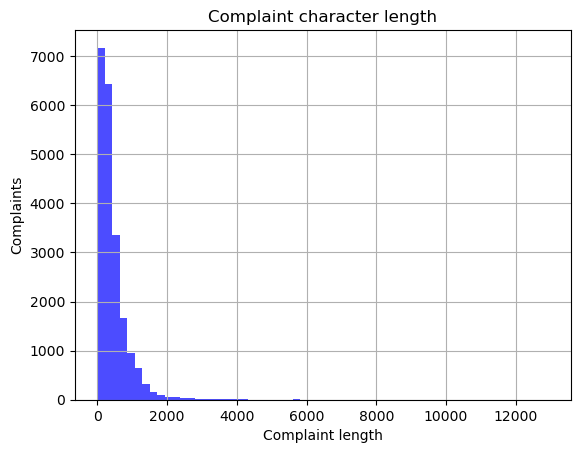

In [35]:
# Visualizamos el nuevo dataframe en base al lenght aplicado en los Complaint
char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

plt.hist(char_len, bins=60, alpha=0.7, color='blue')
plt.xlabel("Complaint length")
plt.ylabel("Complaints")
plt.title("Complaint character length")
plt.grid(True)
plt.show()

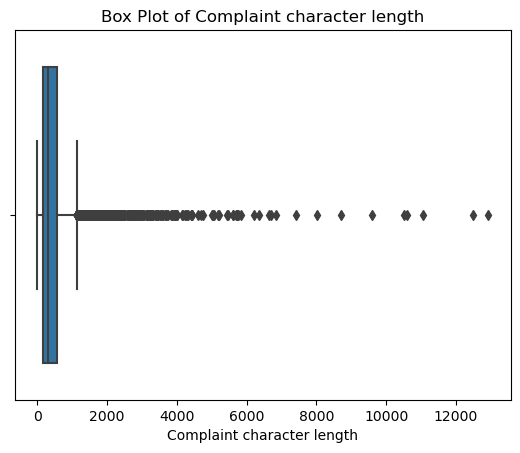

In [36]:
sns.boxplot(x=char_len)
plt.xlabel("Complaint character length")
plt.title("Box Plot of Complaint character length")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rochi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


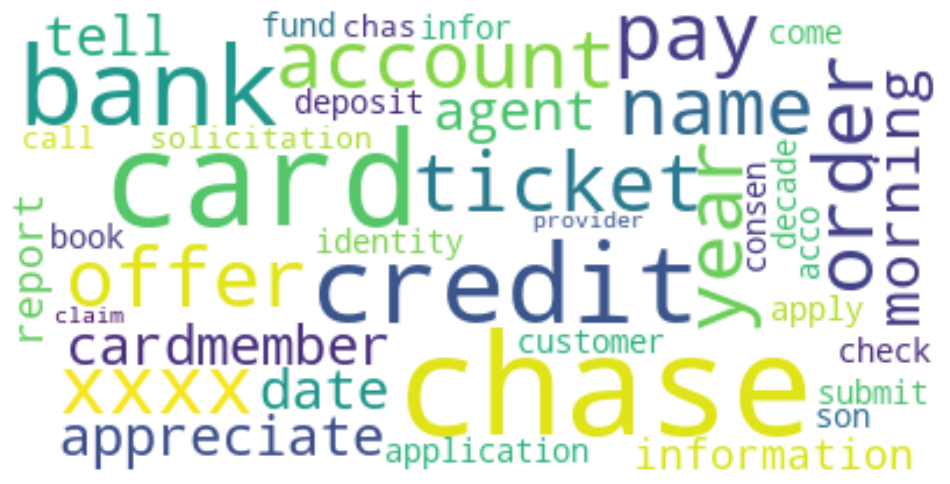

In [38]:
# Utilizando wordcloud encontramos las primeros 40 palabras mediante su frecuencia en todo el texto

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

text_data = str(df_clean['complaint_POS_removed'])

wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=STOPWORDS).generate(text_data)

plt.figure(figsize=[12, 12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [39]:
#Eliminamos -PRON- del cuerpo del texto
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [40]:
df_clean['Complaint_clean']

0        morning name appreciate chase bank cardmember ...
1        xxxx card tell agent date information order up...
2        card report application submit identity consen...
3        book ticket come offer apply ticket card infor...
4        son check deposit chase account fund bank acco...
                               ...                        
21067    chase card customer decade offer solicitation ...
21068    call chas xxxx credit card provider claim purc...
21069    pay risk consumer chase bank chase year trust ...
21070    flawless credit chase credit card chase freedo...
21071    year account jp bank order line credit pay acc...
Name: Complaint_clean, Length: 21072, dtype: object

In [41]:
!pip install mi_modulo

In [42]:
# Obtener los 30 unigramas del nuevo dataframe ya limpio
from collections import Counter

complaints_text = ' '.join(df_clean['Complaint_clean'])
words = complaints_text.split()
word_freq = Counter(words)
top_30_unigrams = word_freq.most_common(30)

df_unigrams = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Frequency'])

print(df_unigrams)


        Unigram  Frequency
0         chase      53926
1       account      43571
2        credit      34088
3          bank      28646
4          card      26589
5       payment      21172
6          call      18191
7        charge      17077
8          time      16063
9          xxxx      13381
10          day      12977
11        check      12469
12          pay      12250
13        money      11962
14       report      11325
15         loan      11001
16        state       9878
17       letter       9670
18  information       9660
19        claim       8722
20  transaction       8656
21       number       8623
22        month       8464
23         tell       8313
24         year       8293
25          fee       8203
26     mortgage       8200
27       amount       8198
28     customer       8164
29      service       8052


In [43]:
# Imprimimos los 10 primeros unigramas del nuevo dataframe ya limpio
complaints_text = ' '.join(df_clean['Complaint_clean'])
words = complaints_text.split()
word_freq = Counter(words)
top_10_unigrams = word_freq.most_common(10)

for word, frequency in top_10_unigrams:
    print(f"{word}: {frequency}")

chase: 53926
account: 43571
credit: 34088
bank: 28646
card: 26589
payment: 21172
call: 18191
charge: 17077
time: 16063
xxxx: 13381


In [44]:
# Obtener los 30 bigramas del nuevo dataframe ya limpio
complaints_text = ' '.join(df_clean['Complaint_clean'])
words = nltk.word_tokenize(complaints_text)
bi_grams = list(bigrams(words))
bigram_freq = Counter(bi_grams)
top_30_bigrams = bigram_freq.most_common(30)

df_bigrams = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])

print(df_bigrams)


                 Bigram  Frequency
0        (credit, card)      12601
1         (chase, bank)       5399
2      (credit, report)       4040
3      (check, account)       3686
4         (call, chase)       3179
5   (customer, service)       3074
6       (chase, credit)       2977
7       (bank, account)       2465
8      (account, chase)       2115
9      (chase, account)       2017
10   (account, account)       1700
11        (phone, call)       1684
12      (account, bank)       1559
13      (credit, score)       1517
14      (letter, chase)       1317
15     (interest, rate)       1286
16      (card, account)       1281
17    (account, credit)       1265
18      (business, day)       1259
19        (card, chase)       1255
20      (phone, number)       1239
21     (credit, bureau)       1229
22        (debit, card)       1124
23     (report, credit)       1119
24      (card, company)       1096
25    (account, number)       1076
26   (payment, payment)       1075
27  (fraud, departme

In [45]:
# Imprimimos los 10 primeros bigramas del nuevo dataframe ya limpio

complaints_text = ' '.join(df_clean['Complaint_clean'])
words = nltk.word_tokenize(complaints_text)
bi_grams = list(bigrams(words))
bigram_freq = Counter(bi_grams)

top_10_bigrams = bigram_freq.most_common(10)

for bigram, frequency in top_10_bigrams:
    print(f"{bigram}: {frequency}")

('credit', 'card'): 12601
('chase', 'bank'): 5399
('credit', 'report'): 4040
('check', 'account'): 3686
('call', 'chase'): 3179
('customer', 'service'): 3074
('chase', 'credit'): 2977
('bank', 'account'): 2465
('account', 'chase'): 2115
('chase', 'account'): 2017


In [46]:
# Obtener los 30 trigramas del nuevo dataframe ya limpio

complaints_text = ' '.join(df_clean['Complaint_clean'])
words = nltk.word_tokenize(complaints_text)
tri_grams = list(ngrams(words, 3))
trigram_freq = Counter(tri_grams)
top_30_trigrams = trigram_freq.most_common(30)

df_trigrams = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])

print(df_trigrams)

                           Trigram  Frequency
0            (chase, credit, card)       2151
1          (credit, card, company)        991
2          (credit, card, account)        889
3            (credit, card, chase)        665
4       (chase, customer, service)        484
5           (charge, credit, card)        456
6           (credit, card, credit)        454
7        (inquiry, credit, report)        409
8        (call, customer, service)        399
9          (chase, check, account)        373
10        (credit, report, credit)        373
11     (credit, reporting, agency)        349
12         (account, credit, card)        341
13        (credit, reporting, act)        330
14            (bank, credit, card)        324
15          (credit, card, charge)        320
16             (call, chase, bank)        319
17            (credit, card, bank)        318
18          (chase, bank, account)        317
19            (card, credit, card)        286
20      (chase, fraud, department)

In [47]:
# Imprimimos los 10 primeros trigramas del nuevo dataframe ya limpio

complaints_text = ' '.join(df_clean['Complaint_clean'])

words = nltk.word_tokenize(complaints_text)
tri_grams = list(ngrams(words, 3))
trigram_freq = Counter(tri_grams)
top_10_trigrams = trigram_freq.most_common(10)

for trigram, frequency in top_10_trigrams:
    print(f"{trigram}: {frequency}")

('chase', 'credit', 'card'): 2151
('credit', 'card', 'company'): 991
('credit', 'card', 'account'): 889
('credit', 'card', 'chase'): 665
('chase', 'customer', 'service'): 484
('charge', 'credit', 'card'): 456
('credit', 'card', 'credit'): 454
('inquiry', 'credit', 'report'): 409
('call', 'customer', 'service'): 399
('chase', 'check', 'account'): 373


Los datos personales del cliente se han enmascarado en el conjunto de datos con xxxx. Eliminamos el texto enmascarado ya que no será de utilidad para nuestro análisis.

In [48]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [49]:
df_clean

complaint_what_happened  \
0      Good morning my name is XXXX XXXX and I apprec...   
1      I upgraded my XXXX XXXX card in XX/XX/2018 and...   
2      Chase Card was reported on XX/XX/2019. However...   
3      On XX/XX/2018, while trying to book a XXXX  XX...   
4      my grand son give me check for {$1600.00} i de...   
...                                                  ...   
21067  After being a Chase Card customer for well ove...   
21068  On Wednesday, XX/XX/XXXX I called Chas, my XXX...   
21069  I am not familiar with XXXX pay and did not un...   
21070  I have had flawless credit for 30 yrs. I've ha...   
21071  Roughly 10+ years ago I closed out my accounts...   

                                   lemmatized_complaints  \
0      good morning name xxxx xxxx appreciate could h...   
1      upgraded xxxx xxxx card tell agent upgrade ann...   
2      chase card report however fraudulent applicati...   
3      try book xxxx xxxx ticket come across offer ap...   
4      grand son give check deposit chase account fun...   
...                                                  ...   
21067  chase card customer well decade offer multiple...   
21068  wednesday xxxxxxxx call chas xxxx xxxx visa cr...   
21069  familiar xxxx pay understand great risk provid...   
21070  flawless credit yrs ive chase credit card chas...   
21071  roughly year ago close account jp morgan chase...   

                                   complaint_POS_removed  length  \
0      morning name appreciate chase bank cardmember ...     175   
1      xxxx card tell agent date information order up...     117   
2      card report application submit identity consen...      81   
3      book ticket come offer apply ticket card infor...     411   
4      son check deposit chase account fund bank acco...     169   
...                                                  ...     ...   
21067  chase card customer decade offer solicitation ...     232   
21068  call chas xxxx credit card provider claim purc...     702   
21069  pay risk consumer chase bank chase year trust ...     695   
21070  flawless credit chase credit card chase freedo...     563   
21071  year account jp bank order line credit pay acc...     252   

                                         Complaint_clean  
0      morning name appreciate chase bank cardmember ...  
1       card tell agent date information order upgrad...  
2      card report application submit identity consen...  
3      book ticket come offer apply ticket card infor...  
4      son check deposit chase account fund bank acco...  
...                                                  ...  
21067  chase card customer decade offer solicitation ...  
21068  call chas  credit card provider claim purchase...  
21069  pay risk consumer chase bank chase year trust ...  
21070  flawless credit chase credit card chase freedo...  
21071  year account jp bank order line credit pay acc...  

[21072 rows x 5 columns]

## Feature Extraction
Convertimos los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [50]:
# Inicializamos TfidfVectorizer 
tfidf = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

In [51]:
dtm = tfidf.fit_transform(df_clean.Complaint_clean)

In [52]:
# Creamos la matriz de términos del documento transformando la columna de quejas presente en df_clean.
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_clean["Complaint_clean"])
pd.DataFrame(tfidf_matrix.toarray(),columns=vectorizer.get_feature_names_out())

__  ___  ____  ________  __________  \
0      0.0  0.0   0.0       0.0         0.0   
1      0.0  0.0   0.0       0.0         0.0   
2      0.0  0.0   0.0       0.0         0.0   
3      0.0  0.0   0.0       0.0         0.0   
4      0.0  0.0   0.0       0.0         0.0   
...    ...  ...   ...       ...         ...   
21067  0.0  0.0   0.0       0.0         0.0   
21068  0.0  0.0   0.0       0.0         0.0   
21069  0.0  0.0   0.0       0.0         0.0   
21070  0.0  0.0   0.0       0.0         0.0   
21071  0.0  0.0   0.0       0.0         0.0   

       ___________________________________________________________________________  \
0                                                    0.0                             
1                                                    0.0                             
2                                                    0.0                             
3                                                    0.0                             
4                                                    0.0                             
...                                                  ...                             
21067                                                0.0                             
21068                                                0.0                             
21069                                                0.0                             
21070                                                0.0                             
21071                                                0.0                             

       __no  _they_   aa  aacount  ...  zero  zeroed  zerofraud  \
0       0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
1       0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
2       0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
3       0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
4       0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
...     ...     ...  ...      ...  ...   ...     ...        ...   
21067   0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
21068   0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
21069   0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
21070   0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   
21071   0.0     0.0  0.0      0.0  ...   0.0     0.0        0.0   

       zeroliability  zip  zipcode  zipcodeaddress  zombie  zone  zoom  
0                0.0  0.0      0.0             0.0     0.0   0.0   0.0  
1                0.0  0.0      0.0             0.0     0.0   0.0   0.0  
2                0.0  0.0      0.0             0.0     0.0   0.0   0.0  
3                0.0  0.0      0.0             0.0     0.0   0.0   0.0  
4                0.0  0.0      0.0             0.0     0.0   0.0   0.0  
...              ...  ...      ...             ...     ...   ...   ...  
21067            0.0  0.0      0.0             0.0     0.0   0.0   0.0  
21068            0.0  0.0      0.0             0.0     0.0   0.0   0.0  
21069            0.0  0.0      0.0             0.0     0.0   0.0   0.0  
21070            0.0  0.0      0.0             0.0     0.0   0.0   0.0  
21071            0.0  0.0      0.0             0.0     0.0   0.0   0.0  

[21072 rows x 15395 columns]

Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea realizamos lo siguiente:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
Adoptamos el enfoque de prueba y error para encontrar la mejor cantidad de topicos para el modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [53]:
# Cargamos el numero de topicos para extraer los topicos
num_topics = 5
nmf_model = NMF(n_components=num_topics)

In [54]:
W=nmf_model.fit_transform(tfidf_matrix)
H=nmf_model.components_

In [55]:
words = np.array(vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics,10)), index=[f'Topic {i+1}' for i in range (num_topics)], columns=[f'Word {i+1}' for i in range(10)]).astype(str)

for i in range(num_topics):
    ix=H[i].argsort()[::-1][:10]
    topic_words.iloc[i]=words[ix]
    
topic_words

Word 1    Word 2   Word 3    Word 4        Word 5       Word 6  \
Topic 1  account      bank    check     money         chase      deposit   
Topic 2   credit      card   report   inquiry         chase      account   
Topic 3     loan  mortgage     home     chase  modification     property   
Topic 4   charge      card      fee     chase       dispute  transaction   
Topic 5  payment       pay  balance  interest         month    statement   

           Word 7    Word 8       Word 9 Word 10  
Topic 1      fund       day         call  branch  
Topic 2   company     score  information  bureau  
Topic 3      year    letter         time    rate  
Topic 4  purchase  merchant         call   claim  
Topic 5       fee    amount         bill     day

In [56]:
#Asignamos cada topico a Complaints

Topic_names = {"Topic 1":"Theft/Dispute Reporting","Topic 2":"Credit card or prepaid card", "Topic 3":"Mortgage/Loan", "Topic 4": "Bank Account Services", "Topic 5": "Others" }
topic_words

Word 1    Word 2   Word 3    Word 4        Word 5       Word 6  \
Topic 1  account      bank    check     money         chase      deposit   
Topic 2   credit      card   report   inquiry         chase      account   
Topic 3     loan  mortgage     home     chase  modification     property   
Topic 4   charge      card      fee     chase       dispute  transaction   
Topic 5  payment       pay  balance  interest         month    statement   

           Word 7    Word 8       Word 9 Word 10  
Topic 1      fund       day         call  branch  
Topic 2   company     score  information  bureau  
Topic 3      year    letter         time    rate  
Topic 4  purchase  merchant         call   claim  
Topic 5       fee    amount         bill     day

In [57]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range (num_topics)])
W['max_topic'] = W.apply(lambda tfidf_matrix: Topic_names.get(tfidf_matrix.idxmax()),axis=1)
W[pd.notnull(W['max_topic'])].head(10)

Topic 1   Topic 2   Topic 3   Topic 4   Topic 5  \
0  0.025516  0.015527  0.023319  0.006739  0.004920   
1  0.009715  0.013767  0.006584  0.009055  0.001905   
2  0.000000  0.058706  0.000055  0.000000  0.000000   
3  0.016803  0.063481  0.016596  0.002969  0.000000   
4  0.075917  0.000000  0.000000  0.000000  0.000056   
5  0.000000  0.047678  0.000000  0.000000  0.000000   
6  0.056975  0.000310  0.002761  0.002899  0.011391   
7  0.005277  0.003560  0.044848  0.001827  0.052521   
8  0.034784  0.003719  0.018906  0.042321  0.001672   
9  0.000000  0.167424  0.000000  0.002861  0.000000   

                     max_topic  
0      Theft/Dispute Reporting  
1  Credit card or prepaid card  
2  Credit card or prepaid card  
3  Credit card or prepaid card  
4      Theft/Dispute Reporting  
5  Credit card or prepaid card  
6      Theft/Dispute Reporting  
7                       Others  
8        Bank Account Services  
9  Credit card or prepaid card

In [58]:
df_clean["topic"]=W["max_topic"]
df_clean.head()

complaint_what_happened  \
0  Good morning my name is XXXX XXXX and I apprec...   
1  I upgraded my XXXX XXXX card in XX/XX/2018 and...   
2  Chase Card was reported on XX/XX/2019. However...   
3  On XX/XX/2018, while trying to book a XXXX  XX...   
4  my grand son give me check for {$1600.00} i de...   

                               lemmatized_complaints  \
0  good morning name xxxx xxxx appreciate could h...   
1  upgraded xxxx xxxx card tell agent upgrade ann...   
2  chase card report however fraudulent applicati...   
3  try book xxxx xxxx ticket come across offer ap...   
4  grand son give check deposit chase account fun...   

                               complaint_POS_removed  length  \
0  morning name appreciate chase bank cardmember ...     175   
1  xxxx card tell agent date information order up...     117   
2  card report application submit identity consen...      81   
3  book ticket come offer apply ticket card infor...     411   
4  son check deposit chase account fund bank acco...     169   

                                     Complaint_clean  \
0  morning name appreciate chase bank cardmember ...   
1   card tell agent date information order upgrad...   
2  card report application submit identity consen...   
3  book ticket come offer apply ticket card infor...   
4  son check deposit chase account fund bank acco...   

                         topic  
0      Theft/Dispute Reporting  
1  Credit card or prepaid card  
2  Credit card or prepaid card  
3  Credit card or prepaid card  
4      Theft/Dispute Reporting

In [59]:
#Creamos un diccionario de Topics
training_data = df_clean[["Complaint_clean","topic"]]

In [60]:
Topic_names = {"Theft/Dispute Reporting":1,"Credit card or prepaid card":2, "Mortgage/Loan":3, "Bank Account Services":4, "Others":5 }

In [61]:
training_data["topic"] = training_data['topic'].map(Topic_names)

C:\Users\rochi\AppData\Local\Temp\ipykernel_24988\4139225492.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
training_data

Complaint_clean  topic
0      morning name appreciate chase bank cardmember ...      1
1       card tell agent date information order upgrad...      2
2      card report application submit identity consen...      2
3      book ticket come offer apply ticket card infor...      2
4      son check deposit chase account fund bank acco...      1
...                                                  ...    ...
21067  chase card customer decade offer solicitation ...      2
21068  call chas  credit card provider claim purchase...      4
21069  pay risk consumer chase bank chase year trust ...      2
21070  flawless credit chase credit card chase freedo...      5
21071  year account jp bank order line credit pay acc...      5

[21072 rows x 2 columns]

## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora se ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, se utilizaran para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [63]:
# Convertimos en Vectorcount
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['Complaint_clean'])

pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [64]:
#Transformamos wordvector a tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

## Model training and evaluation

Se aplicaron 3 modelos para detectar cual de estos es el mejor segun los datos que tenemos
:
* Logistic regression
* Decision Tree
* Random Forest


In [65]:
X = training_data.Complaint_clean
y = training_data.topic

In [66]:
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [67]:
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [68]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

In [69]:
#Regresion Logistica
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [70]:
logreg.score(X_test, y_test)

0.9519741837509491

In [71]:
#Decission tree
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [72]:
dt.score(X_test, y_test)

0.8376993166287016

In [73]:
#Random Forest
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [74]:
rf.score(X_test, y_test)

0.8667425968109339

## Decision de Mejor Modelo

Como se puede observar obtenemos los siguientes Scores dentro de los 3 modelos utilizados

LogisticRegression: 95%
DecissionTree: 84%
Random Forest: 87%

Por lo que el mejor modelo que se puede aplicar entre los 3 es Logistic Regression
